# Trustworthy Scientific Inference for Inverse Problems with Generative Models

# Figure 5 - Case Study III

## Setup

In [1]:
# IMPORTS
import os
import sys
import warnings
import logging

import dill

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import astropy

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from catboost import CatBoostClassifier

from gaiaxpy.core.config import load_xpmerge_from_xml, load_xpsampling_from_xml

from lf2i.plot.parameter_regions import plot_parameter_region_2D
from lf2i.plot.miscellanea import PolygonPatchFixed

from matplotlib.colors import to_rgba
import alphashape

import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch

In [2]:
# DIRECTORY SETUP
src_subdir = "../src/"
if src_subdir not in sys.path:
    sys.path.insert(1, src_subdir)

# Imports from your project
from data import read_catalog, generate_splits, process_all_splits, process_split
from utils import setup_paths, load_vsi, select_spread_out_stars_near_tracks
from vsi import VSI

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-12 17:10:24.709553: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 17:10:26.637895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 17:10:26.637938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12

## Utility Functions

In [3]:
# XP Coefficients Visualization
xp_sampling_grid, xp_merge = load_xpmerge_from_xml()
xp_design_matrices = load_xpsampling_from_xml()

def xp_coeffs_phys(bprp_coeffs: dict) -> np.ndarray:
    """
    Turn the BP/RP coefficient vectors into a physical spectrum.
    """
    bp_spec = bprp_coeffs["bp"].dot(xp_design_matrices["bp"])
    rp_spec = bprp_coeffs["rp"].dot(xp_design_matrices["rp"])
    return (bp_spec * xp_merge["bp"]) + (rp_spec * xp_merge["rp"])

## Data and Objects

### Gaia/APOGEE Catalog

In [4]:
# Full Catalog
data_paths = setup_paths(notebook=True)
catalog_path = os.path.join(data_paths["data"], "xp_apogee_cat.h5")
catalog = read_catalog(catalog_path, filter="good", normalize=False)

### Heldout Catalog

In [5]:
# Heldout data
path = "/home/azureuser/josh/vsi/src/vsi/milkyjay/data/sunlike_holdout_N10.pkl"
with open(path, "rb") as f:
    catalog_holdouts = dill.load(f)

### VSI Objects

In [6]:
# No Selection Bias Setting
# vsi_obj_unbiased = load_vsi("/home/azureuser/josh/vsi/src/vsi/milkyjay/assets/VSI_biasNO_split0.19999999999999996_conf0.9_grid1000000_estnpe_testposterior_verV3_QUALITY_CUTS/VSI_instance_checkpoint_COMPLETE.pkl")
vsi_obj_unbiased = load_vsi("/home/azureuser/josh/vsi/src/vsi/milkyjay/assets/VSI_biasNO_split0.30000000000000004_conf0.9_grid1000000_estnpe_testposterior_verV4_QUALITY_CUTS_REDUCED_CALIB/VSI_instance_checkpoint_COMPLETE.pkl")

In [7]:
# Selection Bias Setting
# vsi_obj_biased = load_vsi("/home/azureuser/josh/vsi/src/vsi/milkyjay/assets/VSI_biasPRISTINE_split1_conf0.9_grid1000000_estnpe_testposterior_verV3_QUALITY_CUTS/VSI_instance_checkpoint_COMPLETE.pkl")
vsi_obj_biased = load_vsi("/home/azureuser/josh/vsi/src/vsi/milkyjay/assets/VSI_biasPRISTINE_split1_conf0.9_grid1000000_estnpe_testposterior_verV4_QUALITY_CUTS_REDUCED_CALIB/VSI_instance_checkpoint_COMPLETE.pkl")

### Metallicity Tracks

In [8]:
# Low and High Metallicity Tracks
A1_fehlow = np.column_stack([
    np.linspace(5100, 4700, 20),  # Teff
    np.linspace(2.6, 2.1, 20)     # logg
])

B1_fehlow = np.column_stack([
    np.linspace(4800, 4300, 20),
    np.linspace(2.1, 1.3, 20)
])

C1_fehlow = np.column_stack([
    np.linspace(4400, 3900, 20),
    np.linspace(1.4, 0.5, 20)
])

D1_fehlow = np.column_stack([
    np.linspace(4200, 3600, 20),
    np.linspace(1.0, 0.0, 20)
])

tracks_fehlow = [A1_fehlow, B1_fehlow, C1_fehlow, D1_fehlow]

A1_fehhigh = np.column_stack([
    np.linspace(4800, 4400, 20),
    np.linspace(2.4, 1.8, 20)
])

B1_fehhigh = np.column_stack([
    np.linspace(4500, 4100, 20),
    np.linspace(1.8, 1.1, 20)
])

C1_fehhigh = np.column_stack([
    np.linspace(4200, 3700, 20),
    np.linspace(1.2, 0.4, 20)
])

D1_fehhigh = np.column_stack([
    np.linspace(4000, 3500, 20),
    np.linspace(0.8, -0.2, 20)
])

tracks_fehhigh = [A1_fehhigh, B1_fehhigh, C1_fehhigh, D1_fehhigh]

selected_idx_low = select_spread_out_stars_near_tracks(
    catalog=catalog,
    tracks=tracks_fehlow,
    target_feh=-1.0,
    feh_tol=0.05,
    k=5
)

selected_stars_low = catalog[selected_idx_low]

selected_idx_high = select_spread_out_stars_near_tracks(
    catalog=catalog,
    tracks=tracks_fehhigh,
    target_feh=0.25,
    feh_tol=0.05,
    k=5
)

selected_stars_high = catalog[selected_idx_high]

## Global Parameters

In [9]:
SEED = 42

### Setup Information

In [10]:
VERSION = "V4_QUALITY_CUTS_REDUCED_CALIB"

# TODO: ACCESS FROM OBJECTS 
CONFIDENCE_LEVEL = vsi_obj_biased.confidence_level
EVALUATION_GRID_SIZE = vsi_obj_biased.evaluation_grid_size
PRIOR_METHOD = vsi_obj_biased.prior_method
ESTIMATOR_METHOD = vsi_obj_biased.test_statistic_method
TEST_STATISTIC_METHOD = vsi_obj_biased.test_statistic_method
CALIBRATION_METHOD = "critical-values"

### Catalog Settings

In [11]:
# Subset of catalog for fast plotting
SUBSET_CATALOG = True
SUBSET_N = 25_000

In [12]:
# Subset based on settings
if SUBSET_CATALOG:
    rng = np.random.default_rng(SEED)
    catalog_length = len(catalog)
    subset_idx = rng.choice(catalog_length, size=SUBSET_N, replace=False)
    catalog = catalog[subset_idx]
else:
    SUBSET_N = len(catalog)

### HPD and FreB Settings

In [13]:
# HPD and FreB
HPD_SLICE_THICKNESS = 0.5
FREB_SLICE_THICKNESS = 0.5
SLICE_DATA = "y_train"

SELECT_REFERENCE_BY_HOLDOUT = True # if false, picking from test set for HPD/FreB sets (rather than holdouts)
IDX_HOLDOUT = 7

REFERENCE_RANDOM = False # if True, will select random reference from test sets
REFERENCE_LOGG_SEARCH = 4.5
REFERENCE_TEFF_SEARCH = 6000
REFERENCE_FE_H_SEARCH = 0.5

USE_CATBOOST_CLASSIFIER_HPD = True

## Results Setup

### No Selection Bias Setting

In [14]:
# Data Setup
vsi_obj_unbiased.parameter_names = ["LOGG", "TEFF", "FE_H"]
param_names_unbiased = vsi_obj_unbiased.parameter_names

train_unbiased = vsi_obj_unbiased.data["y_train"]
test_unbiased = vsi_obj_unbiased.data["y_test"]

logg_idx = param_names_unbiased.index("LOGG")
teff_idx = param_names_unbiased.index("TEFF")
feh_idx = param_names_unbiased.index("FE_H")

teff_train_unbiased = train_unbiased[:SUBSET_N, teff_idx].numpy()
logg_train_unbiased = train_unbiased[:SUBSET_N, logg_idx].numpy()
feh_train_unbiased = train_unbiased[:SUBSET_N, feh_idx].numpy()

teff_test_unbiased = test_unbiased[:SUBSET_N, teff_idx].numpy()
logg_test_unbiased = test_unbiased[:SUBSET_N, logg_idx].numpy()
feh_test_unbiased = test_unbiased[:SUBSET_N, feh_idx].numpy()

if SELECT_REFERENCE_BY_HOLDOUT:
    stars = process_split(catalog_holdouts)
    X_query = stars["X"][IDX_HOLDOUT].unsqueeze(0)
    y_query = stars["y"][IDX_HOLDOUT].unsqueeze(0)

    REFERENCE_STAR_LOGG_UNBIASED = y_query[0][logg_idx].item() # tensor, so use .item()
    REFERENCE_STAR_TEFF_UNBIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_UNBIASED = y_query[0][feh_idx].item()
    
elif REFERENCE_RANDOM:
    stars = vsi_obj_unbiased.find_nearest_input(parameter_names=param_names_unbiased)
    X_query = stars[0][0].unsqueeze(0)
    y_query = stars[2][0].unsqueeze(0)

    REFERENCE_STAR_LOGG_UNBIASED = y_query[0][logg_idx].item()
    REFERENCE_STAR_TEFF_UNBIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_UNBIASED = y_query[0][feh_idx].item()

else:
    stars = vsi_obj_unbiased.find_nearest_input(target_params=[REFERENCE_LOGG_SEARCH, REFERENCE_TEFF_SEARCH, REFERENCE_FE_H_SEARCH],
                                                parameter_names=param_names_unbiased)
    X_query = stars[0][0].unsqueeze(0)
    y_query = stars[2][0].unsqueeze(0)

    REFERENCE_STAR_LOGG_UNBIASED = y_query[0][logg_idx].item()
    REFERENCE_STAR_TEFF_UNBIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_UNBIASED = y_query[0][feh_idx].item()

#### HPD Diagnostics

In [15]:
diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = vsi_obj_unbiased.diagnostics_estimator_info

if USE_CATBOOST_CLASSIFIER_HPD:
    X_classifier = np.array(vsi_obj_unbiased.data["y_test"])
    y_classifier, _ = vsi_obj_unbiased.inference_estimator_info

    classifier = CatBoostClassifier(random_seed=42, verbose=0)
    classifier.fit(X_classifier, y_classifier)

    mean_proba = classifier.predict_proba(X_classifier)[:, 1]

coverage_data_hpd_unbiased = pd.DataFrame({
    "parameter1_logg": out_parameters[:, 0].reshape(-1,),
    "parameter2_teff": out_parameters[:, 1].reshape(-1,),
    "parameter3_feh": out_parameters[:, 2].reshape(-1,),
    "mean_proba": mean_proba.reshape(-1,)
    #"lower_proba": lower_proba.reshape(-1,),
    #"upper_proba": upper_proba.reshape(-1,)
            })

#### HPD Sets

In [16]:
indicator_unbiased, credible_set_unbiased = vsi_obj_unbiased.inference_estimator(parameters=y_query,
                                                                                 samples=X_query)

# cross-section
cond_data = vsi_obj_unbiased.data[SLICE_DATA][:,feh_idx].numpy()
cond_min = np.min(cond_data)
cond_max = np.max(cond_data)
cond_width = cond_max - cond_min

cond_center = REFERENCE_STAR_FE_H_UNBIASED
cond_low = cond_center - HPD_SLICE_THICKNESS * cond_width
cond_high = cond_center + HPD_SLICE_THICKNESS * cond_width

mask_slice = (credible_set_unbiased[0][:, feh_idx] >= cond_low) & (credible_set_unbiased[0][:, feh_idx] <= cond_high)
credible_set_unbiased_slice = credible_set_unbiased[0][mask_slice]

hpd_set_2d_unbiased = credible_set_unbiased_slice[:, [teff_idx, logg_idx]]
hpd_set_2d_unbiased_est_coverage = classifier.predict_proba(y_query.numpy())[:, 1][0]

Computing indicators for 1 credible regions: 100%|██████████| 1/1 [00:19<00:00, 19.55s/it]


#### FreB Diagnostics

In [17]:
diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = vsi_obj_unbiased.diagnostics_lf2i_info

coverage_data_freb_unbiased = pd.DataFrame({
    "parameter1_logg": out_parameters[:, 0].reshape(-1,),
    "parameter2_teff": out_parameters[:, 1].reshape(-1,),
    "parameter3_feh": out_parameters[:, 2].reshape(-1,),
    "mean_proba": mean_proba.reshape(-1,)
    #"lower_proba": lower_proba.reshape(-1,),
    #"upper_proba": upper_proba.reshape(-1,)
            })

#### FreB Sets

In [18]:
confidence_set_unbiased = vsi_obj_unbiased.inference_lf2i(x = X_query)

# cross-section
cond_data = vsi_obj_unbiased.data[SLICE_DATA][:,feh_idx].numpy()
cond_min = np.min(cond_data)
cond_max = np.max(cond_data)
cond_width = cond_max - cond_min

cond_center = REFERENCE_STAR_FE_H_UNBIASED
cond_low = cond_center - HPD_SLICE_THICKNESS * cond_width
cond_high = cond_center + HPD_SLICE_THICKNESS * cond_width

mask_slice = (confidence_set_unbiased[0][:, feh_idx] >= cond_low) & (confidence_set_unbiased[0][:, feh_idx] <= cond_high)
confidence_set_unbiased_slice = confidence_set_unbiased[0][mask_slice]

freb_set_2d_unbiased = confidence_set_unbiased_slice[:, [teff_idx, logg_idx]]
freb_set_2d_unbiased_est_coverage = diagnostics_estimator.predict_proba(y_query.numpy())[:, 1][0]


Constructing confidence regions ...


Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


### Selection Bias Setting

In [19]:
# Data Setup
vsi_obj_biased.parameter_names = ["LOGG", "TEFF", "FE_H"]
param_names_biased = vsi_obj_biased.parameter_names

train_biased = vsi_obj_biased.data["y_train"]
test_biased = vsi_obj_biased.data["y_test"]

logg_idx = param_names_biased.index("LOGG")
teff_idx = param_names_biased.index("TEFF")
feh_idx = param_names_biased.index("FE_H")

teff_train_biased = train_biased[:SUBSET_N, teff_idx].numpy()
logg_train_biased = train_biased[:SUBSET_N, logg_idx].numpy()
feh_train_biased = train_biased[:SUBSET_N, feh_idx].numpy()

teff_test_biased = test_biased[:SUBSET_N, teff_idx].numpy()
logg_test_biased = test_biased[:SUBSET_N, logg_idx].numpy()
feh_test_biased = test_biased[:SUBSET_N, feh_idx].numpy()

if SELECT_REFERENCE_BY_HOLDOUT:
    stars = process_split(catalog_holdouts)
    X_query = stars["X"][IDX_HOLDOUT].unsqueeze(0)
    y_query = stars["y"][IDX_HOLDOUT].unsqueeze(0)

    REFERENCE_STAR_LOGG_BIASED = y_query[0][logg_idx].item() # tensor, so use .item()
    REFERENCE_STAR_TEFF_BIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_BIASED = y_query[0][feh_idx].item()
    
elif REFERENCE_RANDOM:
    stars = vsi_obj_biased.find_nearest_input(parameter_names=param_names_biased)
    X_query = stars[0][0].unsqueeze(0)
    y_query = stars[2][0].unsqueeze(0)

    REFERENCE_STAR_LOGG_BIASED = y_query[0][logg_idx].item()
    REFERENCE_STAR_TEFF_BIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_BIASED = y_query[0][feh_idx].item()

else:
    stars = vsi_obj_biased.find_nearest_input(target_params=[REFERENCE_LOGG_SEARCH, REFERENCE_TEFF_SEARCH, REFERENCE_FE_H_SEARCH],
                                              parameter_names=param_names_biased)
    X_query = stars[0][0].unsqueeze(0)
    y_query = stars[2][0].unsqueeze(0)

    REFERENCE_STAR_LOGG_BIASED = y_query[0][logg_idx].item()
    REFERENCE_STAR_TEFF_BIASED = y_query[0][teff_idx].item()
    REFERENCE_STAR_FE_H_BIASED = y_query[0][feh_idx].item()

#### HPD Diagnostics

In [20]:
diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = vsi_obj_biased.diagnostics_estimator_info

if USE_CATBOOST_CLASSIFIER_HPD:
    X_classifier = np.array(vsi_obj_biased.data["y_test"])
    y_classifier, _ = vsi_obj_biased.inference_estimator_info

    classifier = CatBoostClassifier(random_seed=42, verbose=0)
    classifier.fit(X_classifier, y_classifier)

    mean_proba = classifier.predict_proba(X_classifier)[:, 1]

coverage_data_hpd_biased = pd.DataFrame({
    "parameter1_logg": out_parameters[:, 0].reshape(-1,),
    "parameter2_teff": out_parameters[:, 1].reshape(-1,),
    "parameter3_feh": out_parameters[:, 2].reshape(-1,),
    "mean_proba": mean_proba.reshape(-1,)
    #"lower_proba": lower_proba.reshape(-1,),
    #"upper_proba": upper_proba.reshape(-1,)
            })

#### HPD Sets

In [21]:
indicator_biased, credible_set_biased = vsi_obj_biased.inference_estimator(parameters=y_query,
                                                                           samples=X_query)

# cross-section
cond_data = vsi_obj_biased.data[SLICE_DATA][:,feh_idx].numpy()
cond_min = np.min(cond_data)
cond_max = np.max(cond_data)
cond_width = cond_max - cond_min

cond_center = REFERENCE_STAR_FE_H_BIASED
cond_low = cond_center - HPD_SLICE_THICKNESS * cond_width
cond_high = cond_center + HPD_SLICE_THICKNESS * cond_width

mask_slice = (credible_set_biased[0][:, feh_idx] >= cond_low) & (credible_set_biased[0][:, feh_idx] <= cond_high)
credible_set_biased_slice = credible_set_biased[0][mask_slice]

hpd_set_2d_biased = credible_set_biased_slice[:, [teff_idx, logg_idx]]
hpd_set_2d_biased_est_coverage = classifier.predict_proba(y_query.numpy())[:, 1][0]

Computing indicators for 1 credible regions: 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


#### FreB Diagnostics

In [22]:
diagnostics_estimator, out_parameters, mean_proba, upper_proba, lower_proba = vsi_obj_biased.diagnostics_lf2i_info

coverage_data_freb_biased = pd.DataFrame({
    "parameter1_logg": out_parameters[:, 0].reshape(-1,),
    "parameter2_teff": out_parameters[:, 1].reshape(-1,),
    "parameter3_feh": out_parameters[:, 2].reshape(-1,),
    "mean_proba": mean_proba.reshape(-1,)
    #"lower_proba": lower_proba.reshape(-1,),
    #"upper_proba": upper_proba.reshape(-1,)
            })

#### FreB Sets

In [23]:
confidence_set_biased = vsi_obj_biased.inference_lf2i(x = X_query)

# cross-section
cond_data = vsi_obj_biased.data[SLICE_DATA][:,feh_idx].numpy()
cond_min = np.min(cond_data)
cond_max = np.max(cond_data)
cond_width = cond_max - cond_min

cond_center = REFERENCE_STAR_FE_H_BIASED
cond_low = cond_center - HPD_SLICE_THICKNESS * cond_width
cond_high = cond_center + HPD_SLICE_THICKNESS * cond_width

mask_slice = (confidence_set_biased[0][:, feh_idx] >= cond_low) & (confidence_set_biased[0][:, feh_idx] <= cond_high)
confidence_set_biased_slice = confidence_set_biased[0][mask_slice]

freb_set_2d_biased = confidence_set_biased_slice[:, [teff_idx, logg_idx]]
freb_set_2d_biased_est_coverage = diagnostics_estimator.predict_proba(y_query.numpy())[:, 1][0]


Constructing confidence regions ...


Evaluating posterior for 1 points ...:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:09<00:00,  9.32s/it]


### Reference Spectra Setup

In [24]:
reference_star_spectrum = X_query
reference_star_spectrum  = np.array(reference_star_spectrum.tolist()[0])

REFERENCE_STAR_BPRP = {
    "bp": reference_star_spectrum[:55].astype(float),
    "rp": reference_star_spectrum[55:].astype(float)
    }

REFERENCE_STAR_FLUX = xp_coeffs_phys(REFERENCE_STAR_BPRP)
REFERENCE_STAR_WAVELENGTH = xp_sampling_grid

## Plotting Settings

In [25]:
# Figure Size and Resolution
FIG_VERSION = "V4_QUALITY_CUTS_REDUCED_CALIB"
FIG_SIZE_X = 20
FIG_SIZE_Y = 16
FIG_DPI = 600

### Grid Layout Settings

In [26]:
# Grid and Panels
GRID_V_DIV = 1
GRID_H_DIV1 = 0.33
GRID_H_DIV2 = 0.67
GRID_SPACING = 0.01
GRID_BIGSPACING = 0.02

GRID_EDGECOLOR = "black"
GRID_FACECOLOR = "gainsboro"
GRID_LINEWIDTH = 2

PANEL_LABEL_SIZE = 35
PANEL_LABEL_A = r"\textbf{}"
PANEL_LABEL_B = r"\textbf{}"
PANEL_LABEL_C = r"\textbf{}"

GRID_SPEC_X_N = 1
GRIDSPEC_X_RATIOS = [1]

GRIDSPEC_Y_N = 6
GRIDSPEC_Y_RATIOS = [1.35, 0.05, 0.25, 1.15, 1.15, .1] #1.25

PANEL_TITLE_SIZE = 40
PANEL_TITLE_TOP_DATA_SETTING = r"\textbf{Data setting}"
PANEL_TITLE_TOP_EXAMPLE_DATA = r"\textbf{Example data}"
PANEL_TITLE_MIDDLE_NO_BIAS = r"\textbf{No selection bias}"
PANEL_TITLE_MIDDLE_SELECTION_BIAS = r"\textbf{Selection bias \& follow-up survey}"

SUBPLOTS_X_N_TOP = 7
SUBPLOTS_X_RATIOS_TOP = [0.1, 1, 0.1, 1, 0.1, 1, 0.0001]
SUBPLOTS_Y_N_TOP = 3
SUBPLOTS_Y_RATIOS_TOP = [0.2, 1, 0.1]

SUBPLOTS_X_N_MIDDLE = 9
SUBPLOTS_X_RATIOS_MIDDLE = [0.1, 1, 0.1, 1, 0.25, 1, 0.1, 1, 0.0001]
SUBPLOTS_Y_N_MIDDLE = 3
SUBPLOTS_Y_RATIOS_MIDDLE = [0.1, 1, 0.1]

SUBPLOTS_X_N_BOTTOM = 9
SUBPLOTS_X_RATIOS_BOTTOM = [0.1, 1, 0.1, 1, 0.25, 1, 0.1, 1, 0.0001]
SUBPLOTS_Y_N_BOTTOM = 3
SUBPLOTS_Y_RATIOS_BOTTOM = [0.1, 1, 0.1]

SUBPLOTS_X_N_CMAP = 5
SUBPLOTS_X_RATIOS_CMAP = [0.05, 1, 0.1, 1, 0.05]
SUBPLOTS_Y_N_CMAP = 2
SUBPLOTS_Y_RATIOS_CMAP = [1, 0.1]

BEFORE_AFTER_TEXT_SIZE = 30 # was 25
PANEL_BEFORE_TEXT = r"\textbf{BEFORE}"
PANEL_AFTER_TEXT = r"\textbf{AFTER}"

# ADD CONTROL OVER PANEL TITLE X AND Y LOCATIONS

### Subplot Settings

In [27]:
# Universal
SUBPLOT_FIGSIZE_X = 15
SUBPLOT_FIGSIZE_Y = 12

TITLE_FONTSIZE = 26
LABEL_FONTSIZE = 20
TICK_LABELSIZE = 16
LEGEND_FONTSIZE = 20

In [28]:
# Kiel Diagrams
KIEL_XLABEL = r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{[K]}"
KIEL_YLABEL = r"\textbf{log }$\mathbf{g}$ \textbf{[dex]}"

TARGET_COLOR = "grey"
TARGET_ALPHA = 0.5

PRIOR_COLOR = "blue"
PRIOR_ALPHA = 0.5
PRIOR_FILTER = True

SEPARATION_LINE_COLOR = "black"
SEPARATION_LINE_STYLE = "--"
SEPARATION_LINE_LINEWIDTH = 2

NO_BIAS_KIEL_TITLE = r"\textbf{No selection bias}"
SELECTION_BIAS_KIEL_TITLE = r"\textbf{Selection bias \& follow-up survey}"

NO_BIAS_KIEL_TARGET_LEGEND_LABEL = r"$\pi(\theta)=p_{\mathrm{target}}(\theta)$"
SELECTION_BIAS_KIEL_TARGET_LEGEND_LABEL = r"$p_{\mathrm{target}}(\theta)$"
SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL = r"$\pi(\theta)$"

KIEL_LEGEND_LINEWIDTH = 4
KIEL_LEGEND_LOCATION = "upper left"

KIEL_XLIM_LOW = 2750
KIEL_XLIM_HIGH = 6750

KIEL_YLIM_LOW = -0.5
KIEL_YLIM_HIGH = 5

KDE_LEVELS = 25
KDE_THRESH = 0.01
KDE_LINEWIDTHS = 2

In [29]:
# Spectra
SPECTRA_COLOR = "red"
SPECTRA_LINEWIDTH = 4
SPECTRA_LEGEND_LOCATION = "upper right"

SPECTRA_XLABEL = r"\textbf{Wavelength [nm]}"
SPECTRA_YLABEL = r"\textbf{Flux [10$^{-16}$ W nm$^{-1}$ m$^{-2}$]}"

SPECTRA_TITLE = r"\textbf{Spectrum of Sun-like star}"

In [30]:
# HPD Sets
HPD_REGION_TITLE = r"\textbf{90\% HPD set}"
HPD_REGION_LABEL = r"90\% HPD set"
HPD_REGION_COLOR = "purple"
HPD_REGION_EDGE_ALPHA = 1.0
HPD_REGION_FILL_ALPHA = 0.25
HPD_REGION_ALPHA_SHAPE_PARAM = 0.05
HPD_REGION_LINEWIDTH = 2
HPD_REGION_LINESTYLE="-"
HPD_REGION_PLOT_LEGEND = False

In [31]:
# FreB Sets
FREB_REGION_TITLE = r"\textbf{90\% FreB set}"
FREB_REGION_LABEL = r"90\% FreB set"
FREB_REGION_COLOR = "seagreen"
FREB_REGION_EDGE_ALPHA = 1.0
FREB_REGION_FILL_ALPHA = 0.25
FREB_REGION_ALPHA_SHAPE_PARAM = 0.05
FREB_REGION_LINEWIDTH = 2
FREB_REGION_LINESTYLE="-"
FREB_REGION_PLOT_LEGEND = False

In [32]:
# Diagnostics
CMAP_BOUNDS = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

CMAP_TICK_VALUE = 90
CMAP_TICK_COLOR = "black"
CMAP_TICK_LINEWIDTH = 3
CMAP_EXTEND = "both"
CMAP_EXTENDFRAC = 0.05
CMAP_FORMAT = "%1.1f"
CMAP_TOP_TRIM = 20

HPD_DIAGNOSTICS_TITLE = r"\textbf{HPD local diagnostics}"

FREB_DIAGNOSTICS_TITLE = r"\textbf{FreB local diagnostics}"

### Reference Star Settings

In [33]:
# Plot Reference Star
PLOT_REFERENCE_STAR = True

REFERENCE_STAR_LABEL = "Sun-like star"
REFERENCE_STAR_MARKER = "o"
REFERENCE_STAR_COLOR = "yellow"
REFERENCE_STAR_SIZE = 120
REFERENCE_STAR_LEGEND_SIZE = 12
REFERENCE_STAR_EDGECOLOR = "black"

REFERENCE_STAR_CROSSHAIR_STYLE = ":"
REFERENCE_STAR_CROSSHAIR_COLOR = "red"
REFERENCE_STAR_CROSSHAIR_LINEWIDTH = 2

### Metallicity Track Settings

In [34]:
# Plot Metallicity Track
PLOT_METAL_TRACK = True
METAL_TRACK_TYPE = "low"

METAL_TRACK_COLOR = "gray"
METAL_TRACK_SIZE = 100
METAL_TRACK_LINEWIDTH = 4
METAL_TRACK_LABEL_FLAG = True
METAL_TRACK_LEGEND_DOTSIZE = 4

if METAL_TRACK_TYPE == "low":
    metal_track_catalog = selected_stars_low
    METAL_TRACK_LABEL = -1
elif METAL_TRACK_TYPE == "high":
    metal_track_catalog = selected_stars_high
    METAL_TRACK_LABEL = 0.25

### Other Settings

In [35]:
# Arrow
ARROW_COLOR = "red"
ARROW_STYLE = "-|>"
ARROW_MUTATION_SCALE = 15
ARROW_LINEWIDTH = 5
ARROW_CONNECTIONSTYLE = "arc3,rad=0"

ARROW_DX = 0.06
ARROW_X_LEFT = 0.2
ARROW_X_RIGHT = 0.706
ARROW_Y_BOTH = 0.475

## Subplot Functions

### Panel A Left and Center: Kiel Diagram with No Selection Bias

In [36]:
def plot_kiel_diagram(
        target_x, # teff
        target_y, # logg
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"\textbf{No Selection Bias}",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        target_color="gray",
        target_alpha=0.25,
        target_label=r"$p_{\mathrm{target}}(\theta)$",
        target_label_linewidth=4,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        prior_label=r"$\pi(\theta)$",
        prior_label_linewidth=4,
        separation_line_color="black",
        separation_line_style="--",
        separation_line_linewidth=2,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        reference_star_label="Reference Star",
        reference_star_legend_size=15,
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12
):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=2)
            
    # Separation line
    x_line = np.array([2750, 6750])
    y_line = 5.9 - 0.4 * x_line / 1000
    ax.plot(x_line, 
            y_line, 
            color=separation_line_color, 
            linestyle=separation_line_style, 
            linewidth=separation_line_linewidth,
            zorder=3)

    # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    ax.tick_params(labelsize=tick_labelsize)

    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

    # Legend
    handles = [mlines.Line2D([], [], 
                             color=target_color, 
                             linewidth=target_label_linewidth, 
                             label=target_label)]

    if plot_prior:
        handles.insert(0, mlines.Line2D([], [], 
                                        color=prior_color, 
                                        linewidth=prior_label_linewidth, 
                                        label=prior_label))

    if plot_reference_star:
        handles.insert(len(handles), mlines.Line2D([], [], 
                                        marker=reference_star_marker, 
                                        markersize=reference_star_legend_size, 
                                        markerfacecolor=reference_star_color, 
                                        markeredgecolor=reference_star_edgecolor, 
                                        linestyle="None", 
                                        label=reference_star_label))
        
    ax.legend(handles=handles, fontsize=legend_fontsize, loc=legend_location)

### Panel A Right: Example Spectra for Reference Star

In [37]:
def plot_star_spectrum(
        bprp_coeffs,
        xp_design_matrices,
        xp_merge,
        xp_sampling_grid,
        reference_star_logg,
        reference_star_teff,
        reference_star_feh,
        ax=None,
        title=r"\textbf{Spectrum of Sun-like Star}",
        xlabel=r"\textbf{Wavelength (nm)}",
        ylabel=r"\textbf{Flux (10$^{-16}$ W nm$^{-1}$ m$^{-2}$)}",
        spectra_color="red",
        spectra_linewidth=4,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_edgecolor="black",
        reference_star_label="Reference Star",
        reference_star_legend_size=15,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper right",
        figsize_x=15,
        figsize_y=12
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
                               
    # reconstruct physical flux
    bp_spec = bprp_coeffs["bp"].dot(xp_design_matrices["bp"])
    rp_spec = bprp_coeffs["rp"].dot(xp_design_matrices["rp"])
    flux = bp_spec * xp_merge["bp"] + rp_spec * xp_merge["rp"]

    # spectrum
    sns.lineplot(x=xp_sampling_grid,
                 y=flux/1e-16,
                 color=spectra_color,
                 linewidth=spectra_linewidth,
                 ax=ax,
                 zorder=1)
    
    # titles and labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_labelsize)

    # reference star information
    reference_star_information_label = rf"""
{reference_star_label}
$\log g$ = {reference_star_logg:.2f}
T$_{{\mathrm{{eff}}}}$ = {reference_star_teff:.0f} K
[Fe/H] = {reference_star_feh:.2f}
"""
    
    handle = mlines.Line2D(
        [], [], linestyle="None", marker=reference_star_marker, markersize=reference_star_legend_size,
        markerfacecolor=reference_star_color, markeredgecolor=reference_star_edgecolor,
        label=reference_star_information_label
    )

    ax.legend(handles=[handle], fontsize=legend_fontsize, loc=legend_location)

### Panel B and C Top: HPD and FreB Sets

In [38]:
def plot_hpd_freb_region(
        region_data,
        target_x, # teff
        target_y, # logg
        eval_grid,
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"90\% HPD Set",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        region_label=r"90\% HPD Set",
        region_color="orange",
        region_edge_alpha=1.0,
        region_fill_alpha=0.25,
        region_alpha_shape_param=0.1,
        region_linewidth=2,
        region_linestyle="-",
        region_plot_legend=True,
        target_color="gray",
        target_alpha=0.25,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12,
        plot_eval_grid_points=True,
        plot_alphashape_region=False
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=1)
    
    if plot_eval_grid_points:
        sns.scatterplot(x = eval_grid[:, 1], y = eval_grid[:, 0], # add custom selection of idx
                        marker = "o", color = "gray", alpha = 0.1, ax = ax,
                        size = 0.5)
        sns.scatterplot(x = region_data[:, 0], y = region_data[:, 1],
                        marker = "o", color = "green", alpha = 0.5, ax = ax,
                        size = 0.5)
    
    # 90% HPD or FreB Region
    if plot_alphashape_region:
        
        shape = alphashape.alphashape(region_data, alpha=region_alpha_shape_param)
        patch = PolygonPatchFixed(shape,
                                    fc=to_rgba(region_color, region_fill_alpha),
                                    ec=to_rgba(region_color, region_edge_alpha),
                                    lw=region_linewidth, linestyle=region_linestyle)
        ax.add_patch(patch)

    # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    
    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_labelsize)
    
    # Legend
    if region_plot_legend:
        handle = mlines.Line2D([], [], color=region_color, linewidth=region_linewidth, label=region_label)

        ax.legend(handles=[handle], fontsize=legend_fontsize, loc=legend_location)
                              

### Panel B and C Bottom: Local Diagnostics

In [39]:
class PinGreenNormalize(mcolors.Normalize):
    def __init__(self, vmin=0, vmax=100, vcenter=40, green_index=0.35, clip=False):
        super().__init__(vmin, vmax, clip)
        self.vcenter = vcenter
        self.green_index = green_index

    def __call__(self, value, clip=None):
        x = np.ma.masked_array(value, np.isnan(value))
        result = np.ma.empty(x.shape, dtype=float)

        # below the confidence level
        idx_below = x <= self.vcenter
        if self.vmin < self.vcenter:
            result[idx_below] = (x[idx_below] - self.vmin) / (self.vcenter - self.vmin) * self.green_index
        else:
            # vmin == vcenter
            result[idx_below] = 0.0
        
        # above the confidence level
        idx_above = x > self.vcenter
        if self.vcenter < self.vmax:
            result[idx_above] = self.green_index + (
                (x[idx_above] - self.vcenter) / (self.vmax - self.vcenter)
                * (1.0 - self.green_index)
            )
        else:
            # vcenter == vmax
            result[idx_above] = 1.0
        
        return result

# def create_jetr_cmap(confidence_level=40):
#     """
#     Returns a reversed jet colormap plus a custom normalization that pins 
#     'confidence_level' to a bright green region.
#     """
#     green_index = 0.35  # 0.35 in jet_r is roughly bright green
    
#     cmap = plt.get_cmap('jet_r')
#     norm = PinGreenNormalize(vmin=0, vmax=100, vcenter=confidence_level, green_index=green_index)
#     return cmap, norm

def create_jetr_cmap(confidence_level=90):
    """
    Returns a custom colormap that has green at the high end and pins 
    'confidence_level' to the green region.
    """
    # Create a custom colormap: red -> yellow -> green (instead of red -> yellow -> green -> blue)
    from matplotlib.colors import LinearSegmentedColormap
    
    # Take only the red-yellow-green portion of jet_r (cut off the blue)
    base_cmap = plt.get_cmap('jet_r')
    # Extract colors from jet_r but stop before it gets to blue
    colors = base_cmap(np.linspace(0, 0.35, 256))  # 0.6 stops before blue, ends at green
    cmap = LinearSegmentedColormap.from_list('custom_rg', colors)
    
    green_index = 1.0  # Now 1.0 corresponds to green (the high end)
    norm = PinGreenNormalize(vmin=0, vmax=100, vcenter=confidence_level, green_index=green_index)
    return cmap, norm

In [40]:
def plot_local_diagnostics(
        coverage_data,
        target_x, # teff
        target_y, # logg
        confidence_level=0.90,
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"\textbf{90\% HPD Local Coverage}",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        cmap_top_trim=20,
        cmap_bounds=[76, 80, 84, 88, 92, 96, 100],
        cmap_tick_color="black",
        cmap_extend="both",
        cmap_extend_frac=0.05,
        cmap_format="%1.1f",
        target_color="gray",
        target_alpha=0.25,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        metal_tracks = False,
        metal_tracks_catalog_data = None,
        metal_track_color="purple",
        metal_track_size=100,
        metal_track_linewidth=4,
        metal_track_label_flag=True,
        metal_track_label=-1,
        metal_track_legend_size=4,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12  
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=1)
    
    # heatmap setup
    x_bins = np.histogram_bin_edges(coverage_data["parameter2_teff"], bins='auto')
    y_bins = np.histogram_bin_edges(coverage_data["parameter1_logg"], bins='auto')
    bsum, xedges, yedges = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins],
        weights=np.round(coverage_data["mean_proba"] * 100, 2)
    )
    counts, _, _ = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins]
    )
    heatmap_values = bsum / counts

    # colormap
    base = plt.cm.jet
    cmaplist = [base(i) for i in range(base.N)]
    # reversed & drop top_trim entries
    cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap",
                                                        list(reversed(cmaplist))[:-cmap_top_trim],
                                                        N=base.N - cmap_top_trim
                                                        )
    
    # colormap setup
    bounds = cmap_bounds
    centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
    center_labels = [
        r"$\leq$" + str(int(label)) + r"\%" if label == centers[0] else 
        r"\textbf{" + str(int(label)) + r"\%}" if label == centers[3] else
        str(int(label)) + r"\%" for label in centers
    ]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # heatmap
    ax.imshow(heatmap_values.T[::-1, :],
              cmap=cmap,
              norm=norm,
              aspect="auto",
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
              zorder=2)
    
    # metal tracks
    if metal_tracks == True and metal_tracks_catalog_data is not None:
        sns.scatterplot(x=metal_tracks_catalog_data["TEFF"], 
                        y = metal_tracks_catalog_data["LOGG"], 
                        color=metal_track_color, ax=ax, s=metal_track_size,
                        legend=False)
        sns.lineplot(x=metal_tracks_catalog_data["TEFF"], 
                     y =metal_tracks_catalog_data["LOGG"], 
                     color=metal_track_color, ax=ax,
                     sort = False, linewidth=metal_track_linewidth,
                     legend=False)

   # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    ax.tick_params(labelsize=tick_labelsize)

    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
        
    if metal_track_label_flag==True:
        track_handle = mlines.Line2D([], [], color=metal_track_color,
                                marker='o', linestyle='-',
                                markersize=metal_track_legend_size, linewidth=metal_track_linewidth, label=f"[Fe/H] = {metal_track_label}")
        ax.legend(handles=[track_handle], loc="upper left", fontsize=legend_fontsize)

In [41]:
def plot_local_diagnostics(
        coverage_data,
        target_x, # teff
        target_y, # logg
        confidence_level=0.90,
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"\textbf{90\% HPD Local Coverage}",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        cmap_top_trim=20,
        cmap_bounds=[76, 80, 84, 88, 92, 96, 100],
        cmap_tick_color="black",
        cmap_extend="both",
        cmap_extend_frac=0.05,
        cmap_format="%1.1f",
        target_color="gray",
        target_alpha=0.25,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        metal_tracks = False,
        metal_tracks_catalog_data = None,
        metal_track_color="purple",
        metal_track_size=100,
        metal_track_linewidth=4,
        metal_track_label_flag=True,
        metal_track_label=-1,
        metal_track_legend_size=4,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12  
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=1)
    
    # heatmap setup
    x_bins = np.histogram_bin_edges(coverage_data["parameter2_teff"], bins='auto')
    y_bins = np.histogram_bin_edges(coverage_data["parameter1_logg"], bins='auto')
    bsum, xedges, yedges = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins],
        weights=np.round(coverage_data["mean_proba"] * 100, 2)
    )
    counts, _, _ = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins]
    )
    heatmap_values = bsum / counts

    # colormap - updated to use create_jetr_cmap
    cmap, norm = create_jetr_cmap(confidence_level=confidence_level*100)
    
    # colormap setup
    bounds = cmap_bounds
    centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
    center_labels = [
        r"$\leq$" + str(int(label)) + r"\%" if label == centers[0] else 
        r"$\mathbf{" + str(int(label)) + r"}$\textbf{\%}" if abs(label - confidence_level*100) <= 1e-6 else  # Bold at confidence level
        str(int(label)) + r"\%" for label in centers
    ]
    # Use the norm from create_jetr_cmap instead of BoundaryNorm
    # norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  # Commented out

    # heatmap
    ax.imshow(heatmap_values.T[::-1, :],
              cmap=cmap,
              norm=norm,
              aspect="auto",
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
              zorder=2)
    
    # metal tracks
    if metal_tracks == True and metal_tracks_catalog_data is not None:
        sns.scatterplot(x=metal_tracks_catalog_data["TEFF"], 
                        y=metal_tracks_catalog_data["LOGG"], 
                        color=metal_track_color, ax=ax, s=metal_track_size,
                        legend=False,
                        zorder=4)
        sns.lineplot(x=metal_tracks_catalog_data["TEFF"], 
                     y=metal_tracks_catalog_data["LOGG"], 
                     color=metal_track_color, ax=ax,
                     sort=False, linewidth=metal_track_linewidth,
                     legend=False,
                     zorder=4)

   # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    ax.tick_params(labelsize=tick_labelsize)

    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
        
    if metal_track_label_flag==True:
        track_handle = mlines.Line2D([], [], color=metal_track_color,
                                marker='o', linestyle='-',
                                markersize=metal_track_legend_size, linewidth=metal_track_linewidth, label=f"[Fe/H] = {metal_track_label}")
        ax.legend(handles=[track_handle], loc="upper left", fontsize=legend_fontsize)

In [42]:
class PinGreenNormalize(mcolors.Normalize):
    def __init__(self, vmin=0, vmax=100, vcenter=90, green_index=0.9, clip=False):
        super().__init__(vmin, vmax, clip)
        self.vcenter = vcenter
        self.green_index = green_index

    def __call__(self, value, clip=None):
        x = np.ma.masked_array(value, np.isnan(value))
        result = np.ma.empty(x.shape, dtype=float)

        # below the confidence level
        idx_below = x <= self.vcenter
        if self.vmin < self.vcenter:
            result[idx_below] = (x[idx_below] - self.vmin) / (self.vcenter - self.vmin) * self.green_index
        else:
            # vmin == vcenter
            result[idx_below] = 0.0
        
        # above the confidence level
        idx_above = x > self.vcenter
        if self.vcenter < self.vmax:
            result[idx_above] = self.green_index + (
                (x[idx_above] - self.vcenter) / (self.vmax - self.vcenter)
                * (1.0 - self.green_index)
            )
        else:
            # vcenter == vmax
            result[idx_above] = 1.0
        
        return result

# def create_jetr_cmap(confidence_level=40):
#     """
#     Returns a reversed jet colormap plus a custom normalization that pins 
#     'confidence_level' to a bright green region.
#     """
#     green_index = 0.35  # 0.35 in jet_r is roughly bright green
    
#     cmap = plt.get_cmap('jet_r')
#     norm = PinGreenNormalize(vmin=0, vmax=100, vcenter=confidence_level, green_index=green_index)
#     return cmap, norm

def create_jetr_cmap(confidence_level=90, green_index=0.9):
    """
    Returns a custom colormap that has green at the high end and pins 
    'confidence_level' to the green region.
    """
    # Create a custom colormap: red -> yellow -> green (instead of red -> yellow -> green -> blue)
    from matplotlib.colors import LinearSegmentedColormap
    
    # Take only the red-yellow-green portion of jet_r (cut off the blue)
    base_cmap = plt.get_cmap('jet_r')
    # Extract colors from jet_r but stop before it gets to blue
    colors = base_cmap(np.logspace(-1.5, np.log10(0.5), 10))
    cmap = LinearSegmentedColormap.from_list('custom_rg', colors)

    norm = PinGreenNormalize(vmin=0, vmax=100, vcenter=confidence_level, green_index=green_index)
    return cmap, norm

In [43]:
base_cmap = plt.get_cmap("jet_r")
colors = base_cmap(np.logspace(0, np.log10(0.5), 10))
colors

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.        , 0.82085561, 1.        ],
       [0.        , 0.06470588, 1.        , 1.        ],
       [0.        , 0.31568627, 1.        , 1.        ],
       [0.        , 0.55098039, 1.        , 1.        ],
       [0.        , 0.77058824, 1.        , 1.        ],
       [0.06008855, 0.9745098 , 0.90765338, 1.        ],
       [0.21189121, 1.        , 0.75585073, 1.        ],
       [0.35104364, 1.        , 0.61669829, 1.        ],
       [0.47754586, 1.        , 0.49019608, 1.        ]])

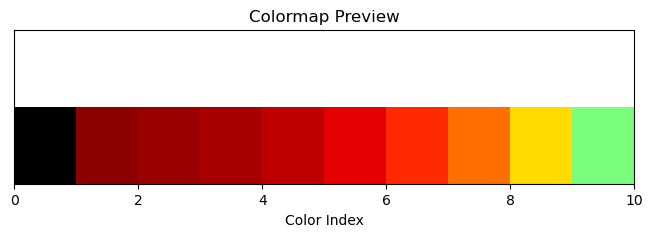

In [44]:
import matplotlib.pyplot as plt
import numpy as np

base_cmap = plt.get_cmap("jet_r")
colors = base_cmap(np.logspace(-2, np.log10(0.5), 10))

colors[0] = [0, 0, 0, 1]

# Create a horizontal color bar preview
fig, ax = plt.subplots(figsize=(8, 2))
for i, color in enumerate(colors):
    ax.barh(0, 1, left=i, color=color, height=1)

ax.set_xlim(0, len(colors))
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('Color Index')
ax.set_title('Colormap Preview')
ax.set_yticks([])
plt.show()

In [45]:
def create_custom_cmap(confidence_level=87):
    """
    Returns a custom colormap using log-spaced jet_r colors that pins 
    'confidence_level' (87) and above to green.
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    # Your specific color setup
    base_cmap = plt.get_cmap("jet_r")
    colors = base_cmap(np.logspace(-2.25, np.log10(0.5), 10))
    
    # Create custom colormap from your colors
    cmap = LinearSegmentedColormap.from_list('custom_log_jet', colors, N=256)
    
    # Pin confidence_level and above to green (at the high end)
    green_index = 1.0  # Green at the maximum end
    norm = PinGreenNormalize(vmin=0, vmax=100, vcenter=confidence_level, green_index=green_index)
    
    return cmap, norm

def create_custom_cmap(confidence_level=87):
    """
    Returns a custom colormap using log-spaced jet_r colors.
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    # Your specific color setup
    base_cmap = plt.get_cmap("jet_r")
    colors = base_cmap(np.logspace(-2, np.log10(0.5), 10))

    colors[0] = [0, 0, 0, 1]
    
    # Create custom colormap from your colors
    cmap = LinearSegmentedColormap.from_list('custom_log_jet', colors, N=256)
    
    # Set bad values (NaN) to white
    cmap.set_bad(color='white', alpha=1)
    
    return cmap


In [46]:
def plot_local_diagnostics(
        coverage_data,
        target_x, # teff
        target_y, # logg
        confidence_level=0.90,
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"\textbf{90\% HPD Local Coverage}",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        cmap_top_trim=20,
        cmap_bounds=[76, 80, 84, 88, 92, 96, 100],
        cmap_tick_color="black",
        cmap_extend="both",
        cmap_extend_frac=0.05,
        cmap_format="%1.1f",
        target_color="gray",
        target_alpha=0.25,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        metal_tracks = False,
        metal_tracks_catalog_data = None,
        metal_track_color="purple",
        metal_track_size=100,
        metal_track_linewidth=4,
        metal_track_label_flag=True,
        metal_track_label=-1,
        metal_track_legend_size=4,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12  
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=1)
    
    # heatmap setup
    # Your data processing (same as reference)
    x_bins = np.histogram_bin_edges(coverage_data["parameter2_teff"], bins='auto')
    y_bins = np.histogram_bin_edges(coverage_data["parameter1_logg"], bins='auto')
    bsum, xedges, yedges = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins],
        weights=np.round(coverage_data["mean_proba"] * 100, 2)
    )
    counts, _, _ = np.histogram2d(
        coverage_data["parameter2_teff"],
        coverage_data["parameter1_logg"],
        bins=[x_bins, y_bins]
    )
    heatmap_values = bsum / counts

    # Custom colormap with 87+ as green
    # cmap, norm = create_custom_cmap(confidence_level=87)

    cmap = create_custom_cmap(confidence_level=85)
    bounds = CMAP_BOUNDS
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # Colormap bounds for 87% focus
    #bounds = [0, 20, 40, 60, 75, 80, 85, 87, 90, 95, 100]
    #centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
    # center_labels = [
    #     r"$\leq$" + str(int(label)) + r"\%" if label == centers[0] else 
    #     r"$\mathbf{" + str(int(label)) + r"}$\textbf{\%}" if abs(label - 87) <= 1e-6 else  # Bold at 87%
    #     str(int(label)) + r"\%" for label in centers
    # ]
    # norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    # Heatmap with custom colormap
    ax.imshow(heatmap_values.T[::-1, :],
            cmap=cmap,
            norm=norm,
            aspect="auto",
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            zorder=2,
            interpolation="none")
    
    # metal tracks
    if metal_tracks == True and metal_tracks_catalog_data is not None:
        sns.scatterplot(x=metal_tracks_catalog_data["TEFF"], 
                        y=metal_tracks_catalog_data["LOGG"], 
                        color=metal_track_color, ax=ax, s=metal_track_size,
                        legend=False,
                        zorder=4,
                        alpha=0.85)
        sns.lineplot(x=metal_tracks_catalog_data["TEFF"], 
                     y=metal_tracks_catalog_data["LOGG"], 
                     color=metal_track_color, ax=ax,
                     sort=False, linewidth=metal_track_linewidth,
                     legend=False,
                     zorder=4,
                     alpha=0.8)

   # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    ax.tick_params(labelsize=tick_labelsize)

    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
        
    if metal_track_label_flag==True:
        track_handle = mlines.Line2D([], [], color=metal_track_color,
                                marker='o', linestyle='-',
                                markersize=metal_track_legend_size, linewidth=metal_track_linewidth, label=f"[Fe/H] = {metal_track_label}")
        ax.legend(handles=[track_handle], loc="upper left", fontsize=legend_fontsize)

# Figure

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contou

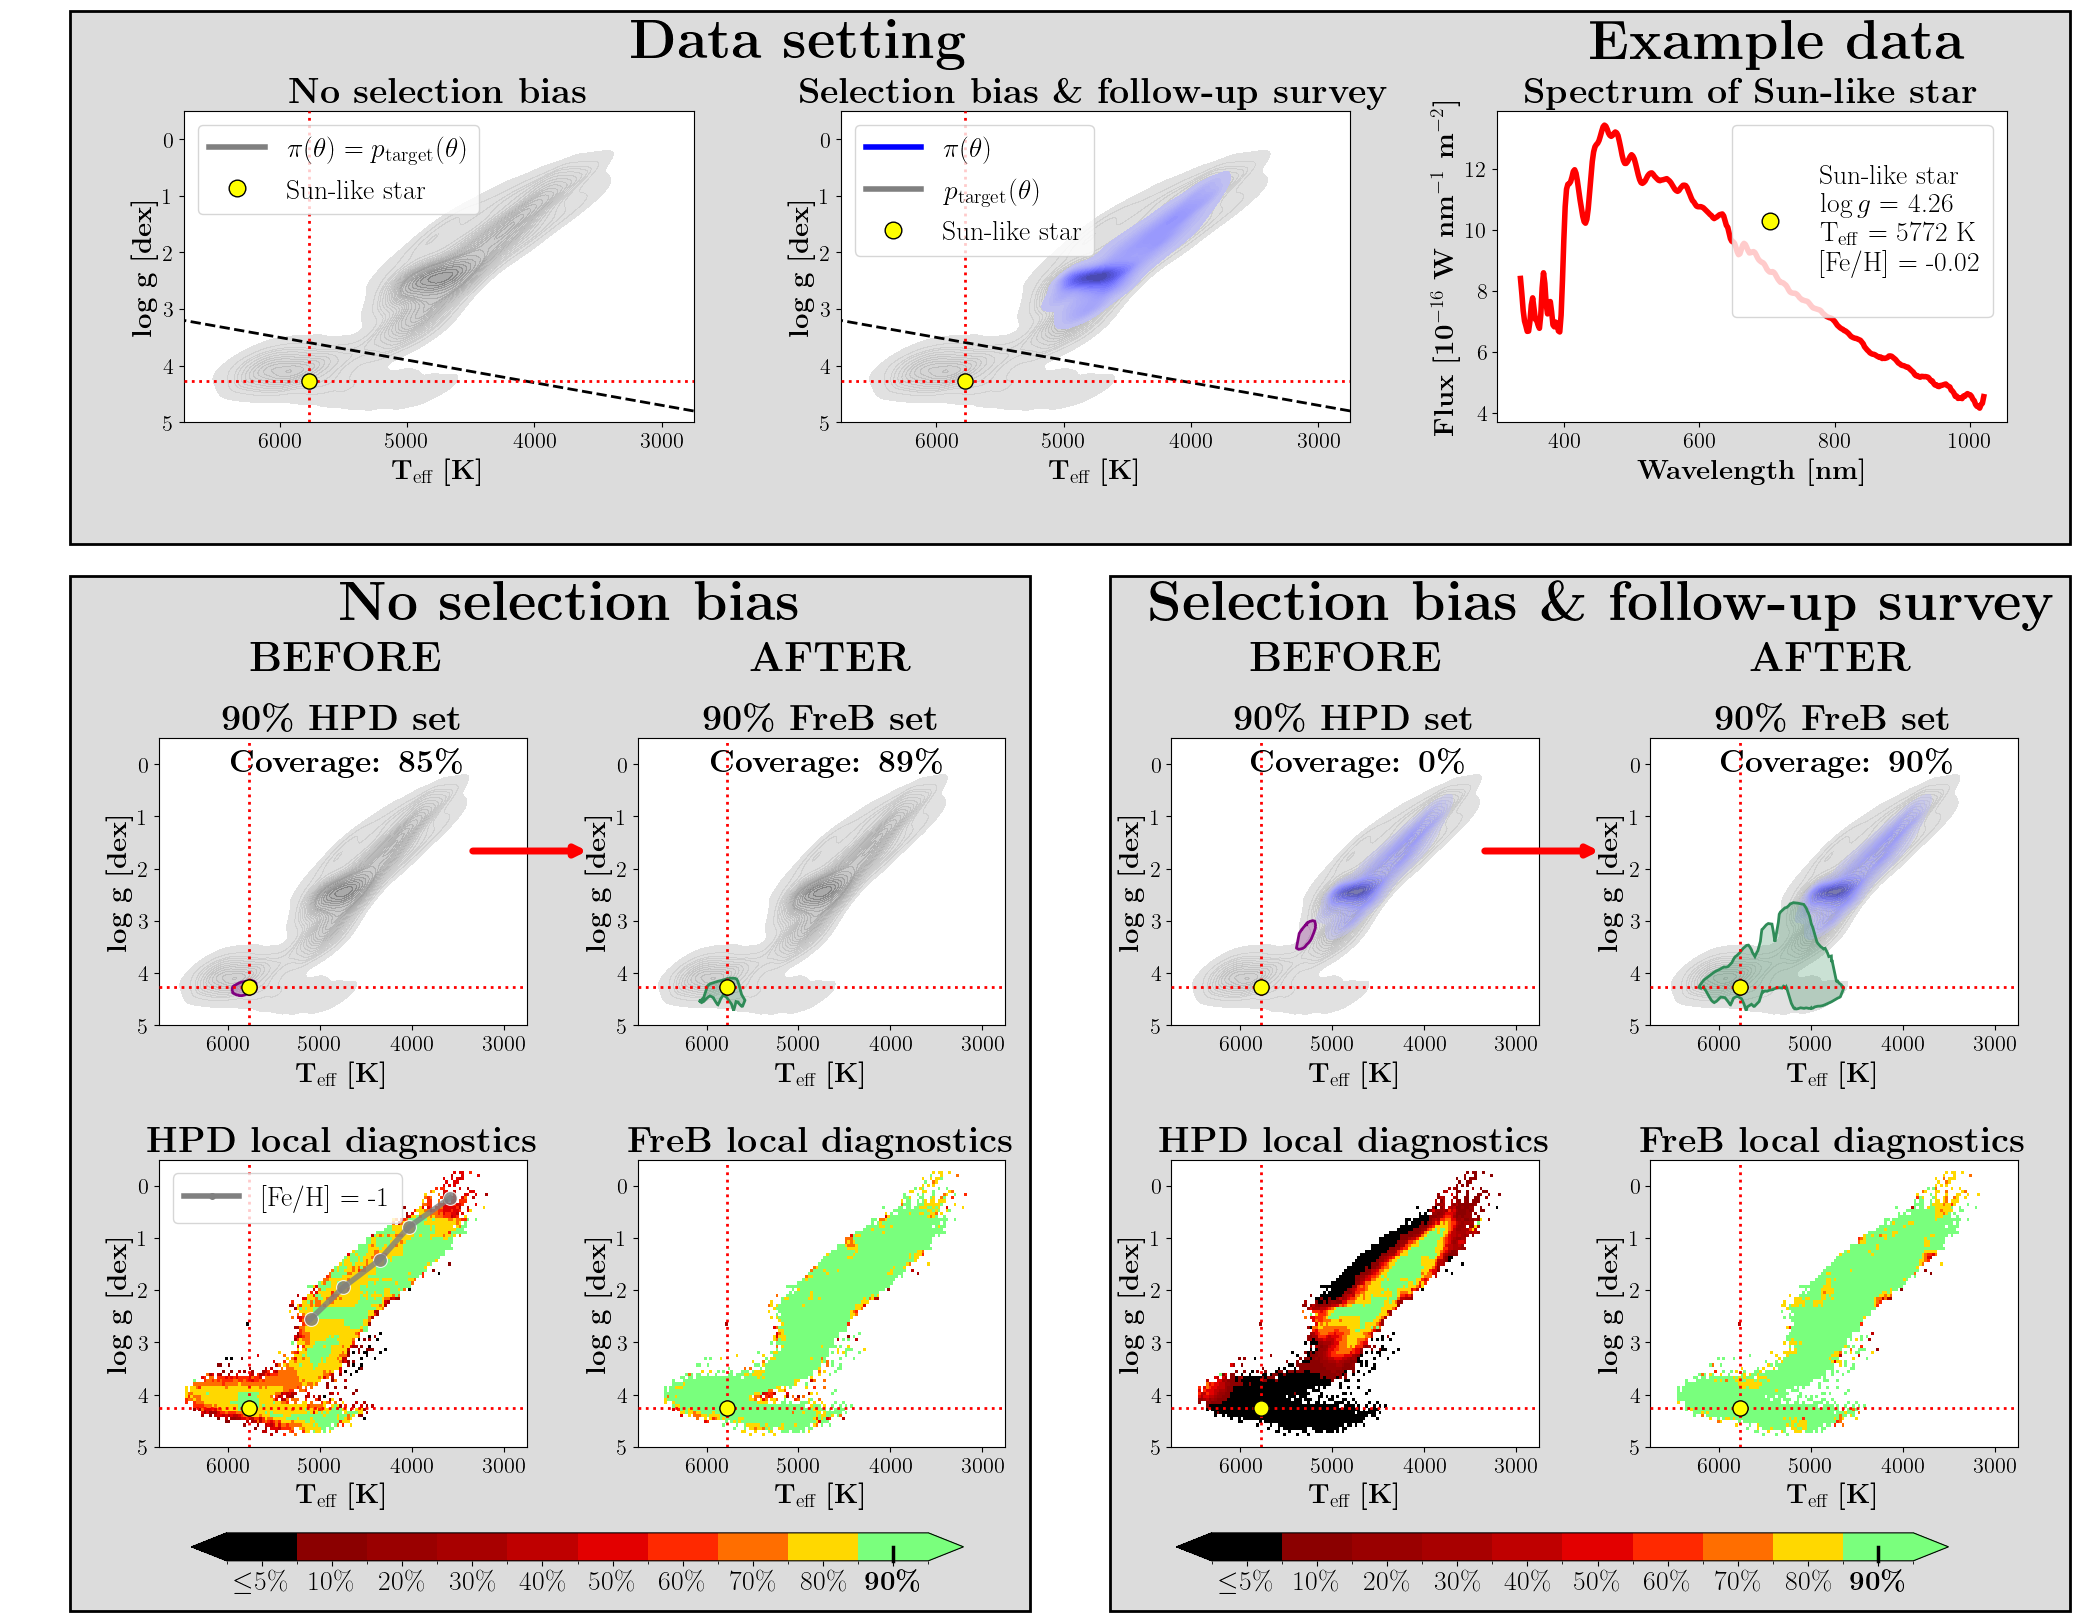

In [47]:
# SETUP
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

fig = plt.figure(figsize=(FIG_SIZE_X, FIG_SIZE_Y))

# -- LAYOUT DIVISIONS -- #
v_div = GRID_V_DIV  # vertical split: top vs. bottom
h_div1 = GRID_H_DIV1  # horizontal division 1
h_div2 = GRID_H_DIV2  # horizontal division 2
spacing = GRID_SPACING  # narrow spacing between panels
bigspacing = GRID_BIGSPACING # wider spacing between B and C
# -------------------- #

# -- SHADED RECTANGLES -- #
# PANEL A
fig.add_artist(patches.Rectangle(
    (0, v_div*2/3), 
    1, v_div*1/3,
    transform=fig.transFigure,
    edgecolor=GRID_EDGECOLOR, 
    facecolor=GRID_FACECOLOR, 
    linewidth=GRID_LINEWIDTH, 
    zorder=0
))

# PANEL B
fig.add_artist(patches.Rectangle(
    (0, 0), 
    0.5 - bigspacing, v_div*2/3 - bigspacing,
    transform=fig.transFigure,
    edgecolor=GRID_EDGECOLOR,
    facecolor=GRID_FACECOLOR,
    linewidth=GRID_LINEWIDTH,
    zorder=0
))

# PANEL C
fig.add_artist(patches.Rectangle(
    (0.5 + bigspacing, 0), 
    0.5 - bigspacing, v_div*2/3 - bigspacing,
    transform=fig.transFigure,
    edgecolor=GRID_EDGECOLOR,
    facecolor=GRID_FACECOLOR, 
    linewidth=GRID_LINEWIDTH,
    zorder=0
))
# -------------------- #

# --- PANEL LABELS --- #
panel_label_size = PANEL_LABEL_SIZE

# Panel A
fig.text(-0.03, v_div*3/3 - 2*spacing, PANEL_LABEL_A, fontsize=panel_label_size)

# Panel B
fig.text(-0.03, v_div*2/3 - 4.5*spacing, PANEL_LABEL_B, fontsize=panel_label_size)

# Panel C
fig.text(0.5 + bigspacing -0.03, v_div*2/3 - 4.5*spacing, PANEL_LABEL_C, fontsize=panel_label_size)
# -------------------- #

# --- GRIDSPEC LAYOUT: MAIN LAYOUT ---
top_level_gridspec = gridspec.GridSpec(
    GRIDSPEC_Y_N, GRID_SPEC_X_N,
    height_ratios=GRIDSPEC_Y_RATIOS,
    width_ratios=GRIDSPEC_X_RATIOS
)
# -------------------- #

# -- PANEL TOP: DATA SETTINGS -- #
panel_title_size = PANEL_TITLE_SIZE
fig.text(0.85*h_div1, v_div*3/3 - 1.5*bigspacing, PANEL_TITLE_TOP_DATA_SETTING, fontsize=panel_title_size)
fig.text(0.76, v_div*3/3 - 1.5*bigspacing, PANEL_TITLE_TOP_EXAMPLE_DATA, fontsize=panel_title_size)

width_ratios = SUBPLOTS_X_RATIOS_TOP
height_ratios = SUBPLOTS_Y_RATIOS_TOP
panel_top = gridspec.GridSpecFromSubplotSpec(
    SUBPLOTS_Y_N_TOP, SUBPLOTS_X_N_TOP,
    subplot_spec=top_level_gridspec[0, 0],
    width_ratios=width_ratios,
    height_ratios=height_ratios
)

# PANEL TOP LEFT: UNBIASED SETTING KIEL DIAGRAM
ax_TOP_LEFT = fig.add_subplot(panel_top[1, 1])

plot_kiel_diagram(
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        prior_x=None,
        prior_y=None,
        ax=ax_TOP_LEFT,
        title=NO_BIAS_KIEL_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        target_label=NO_BIAS_KIEL_TARGET_LEGEND_LABEL,
        target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
        prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
        separation_line_color=SEPARATION_LINE_COLOR,
        separation_line_style=SEPARATION_LINE_STYLE,
        separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=True,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        reference_star_label=REFERENCE_STAR_LABEL,
        reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y
)

# PANEL TOP MIDDLE: BIASED DATA SETTING KIEL DIAGRAM
ax_TOP_MIDDLE = fig.add_subplot(panel_top[1, 3])

plot_kiel_diagram(
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        prior_x=teff_train_biased,
        prior_y=logg_train_biased,
        ax=ax_TOP_MIDDLE,
        title=SELECTION_BIAS_KIEL_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        target_label=SELECTION_BIAS_KIEL_TARGET_LEGEND_LABEL,
        target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
        plot_prior=True,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA + 0.5,
        prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
        prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
        separation_line_color=SEPARATION_LINE_COLOR,
        separation_line_style=SEPARATION_LINE_STYLE,
        separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=True,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        reference_star_label=REFERENCE_STAR_LABEL,
        reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y
)

# PANEL TOP RIGHT: RP SPECTRA
ax_TOP_RIGHT = fig.add_subplot(panel_top[1, 5])

plot_star_spectrum(
        bprp_coeffs=REFERENCE_STAR_BPRP,
        xp_design_matrices=xp_design_matrices,
        xp_merge=xp_merge,
        xp_sampling_grid=xp_sampling_grid,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_feh=REFERENCE_STAR_FE_H_BIASED,
        ax=ax_TOP_RIGHT,
        title=SPECTRA_TITLE,
        xlabel=SPECTRA_XLABEL,
        ylabel=SPECTRA_YLABEL,
        spectra_color=SPECTRA_COLOR,
        spectra_linewidth=SPECTRA_LINEWIDTH,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        reference_star_label=REFERENCE_STAR_LABEL,
        reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=SPECTRA_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y
)

# -------------------- #

# -- PANEL MIDDLE: HPD AND FREB SETS -- #

panel_title_size = PANEL_TITLE_SIZE
fig.text(0.135, v_div*2/3 - 2.35*bigspacing, PANEL_TITLE_MIDDLE_NO_BIAS, fontsize=panel_title_size)
fig.text(0.54, v_div*2/3 - 2.35*bigspacing, PANEL_TITLE_MIDDLE_SELECTION_BIAS, fontsize=panel_title_size)

panel_title_size = BEFORE_AFTER_TEXT_SIZE
fig.text(0.09, v_div*2/3 - 3.95*bigspacing, PANEL_BEFORE_TEXT, fontsize=panel_title_size)
fig.text(0.34, v_div*2/3 - 3.95*bigspacing, PANEL_AFTER_TEXT, fontsize=panel_title_size)

panel_title_size = BEFORE_AFTER_TEXT_SIZE
fig.text(0.59, v_div*2/3 - 3.95*bigspacing, PANEL_BEFORE_TEXT, fontsize=panel_title_size)
fig.text(0.84, v_div*2/3 - 3.95*bigspacing, PANEL_AFTER_TEXT, fontsize=panel_title_size)

set_coverage_text_size = LEGEND_FONTSIZE + 3
fig.text(0.08, v_div*1/2 - -1.25*bigspacing, rf"\textbf{{Coverage: {int(round(hpd_set_2d_unbiased_est_coverage, 2)*100)}\%}}", fontsize=set_coverage_text_size)
fig.text(0.32, v_div*1/2 - -1.25*bigspacing, rf"\textbf{{Coverage: {int(round(freb_set_2d_unbiased_est_coverage, 2)*100)}\%}}", fontsize=set_coverage_text_size)
fig.text(0.59, v_div*1/2 - -1.25*bigspacing, rf"\textbf{{Coverage: {int(round(hpd_set_2d_biased_est_coverage, 2)*100)}\%}}", fontsize=set_coverage_text_size)
fig.text(0.825, v_div*1/2 - -1.25*bigspacing, rf"\textbf{{Coverage: {int(round(freb_set_2d_biased_est_coverage, 2)*100)}\%}}", fontsize=set_coverage_text_size)

width_ratios = SUBPLOTS_X_RATIOS_MIDDLE
height_ratios = SUBPLOTS_Y_RATIOS_MIDDLE
panel_middle = gridspec.GridSpecFromSubplotSpec(
    SUBPLOTS_Y_N_MIDDLE, SUBPLOTS_X_N_MIDDLE,
    subplot_spec=top_level_gridspec[3, 0],
    width_ratios=width_ratios,
    height_ratios=height_ratios
)

# PANEL MIDDLE LEFT: UNBIASED HPD SET
ax_MIDDLE_LEFT = fig.add_subplot(panel_middle[1, 1])

plot_hpd_freb_region(
        region_data=hpd_set_2d_unbiased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        eval_grid=vsi_obj_biased.evaluation_grid,
        prior_x=None,
        prior_y=None,
        ax=ax_MIDDLE_LEFT,
        title=HPD_REGION_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        region_label=HPD_REGION_LABEL,
        region_color=HPD_REGION_COLOR,
        region_edge_alpha=HPD_REGION_EDGE_ALPHA,
        region_fill_alpha=HPD_REGION_FILL_ALPHA,
        region_alpha_shape_param=HPD_REGION_ALPHA_SHAPE_PARAM,
        region_linewidth=HPD_REGION_LINEWIDTH,
        region_linestyle=HPD_REGION_LINESTYLE,
        region_plot_legend=HPD_REGION_PLOT_LEGEND,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y,
        plot_alphashape_region=True,
        plot_eval_grid_points=False
)

# PANEL MIDDLE MIDDLE LEFT: UNBIASED FREB SET
ax_MIDDLE_MIDDLE_LEFT = fig.add_subplot(panel_middle[1, 3])

plot_hpd_freb_region(
        region_data=freb_set_2d_unbiased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        eval_grid=vsi_obj_biased.evaluation_grid,
        prior_x=None,
        prior_y=None,
        ax=ax_MIDDLE_MIDDLE_LEFT,
        title=FREB_REGION_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        region_label=FREB_REGION_LABEL,
        region_color=FREB_REGION_COLOR,
        region_edge_alpha=FREB_REGION_EDGE_ALPHA,
        region_fill_alpha=FREB_REGION_FILL_ALPHA,
        region_alpha_shape_param=FREB_REGION_ALPHA_SHAPE_PARAM,
        region_linewidth=FREB_REGION_LINEWIDTH,
        region_linestyle=FREB_REGION_LINESTYLE,
        region_plot_legend=FREB_REGION_PLOT_LEGEND,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y,
        plot_alphashape_region=True,
        plot_eval_grid_points=False
)

# PANEL MIDDLE MIDDLE RIGHT: BIASED HPD SET
ax_MIDDLE_MIDDLE_RIGHT = fig.add_subplot(panel_middle[1, 5])

plot_hpd_freb_region(
        region_data=hpd_set_2d_biased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        eval_grid=vsi_obj_biased.evaluation_grid,
        prior_x=teff_train_biased,
        prior_y=logg_train_biased,
        ax=ax_MIDDLE_MIDDLE_RIGHT,
        title=HPD_REGION_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        region_label=HPD_REGION_LABEL,
        region_color=HPD_REGION_COLOR,
        region_edge_alpha=HPD_REGION_EDGE_ALPHA,
        region_fill_alpha=HPD_REGION_FILL_ALPHA,
        region_alpha_shape_param=HPD_REGION_ALPHA_SHAPE_PARAM,
        region_linewidth=HPD_REGION_LINEWIDTH,
        region_linestyle=HPD_REGION_LINESTYLE,
        region_plot_legend=HPD_REGION_PLOT_LEGEND,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        plot_prior=True,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y,
        plot_alphashape_region=True,
        plot_eval_grid_points=False
)

# PANEL MIDDLE RIGHT: BIASED FREB SET
ax_MIDDLE_RIGHT = fig.add_subplot(panel_middle[1, 7])

plot_hpd_freb_region(
        region_data=freb_set_2d_biased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        eval_grid=vsi_obj_biased.evaluation_grid, 
        prior_x=teff_train_biased,
        prior_y=logg_train_biased,
        ax=ax_MIDDLE_RIGHT,
        title=FREB_REGION_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        region_label=FREB_REGION_LABEL,
        region_color=FREB_REGION_COLOR,
        region_edge_alpha=FREB_REGION_EDGE_ALPHA,
        region_fill_alpha=FREB_REGION_FILL_ALPHA,
        region_alpha_shape_param=FREB_REGION_ALPHA_SHAPE_PARAM,
        region_linewidth=FREB_REGION_LINEWIDTH,
        region_linestyle=FREB_REGION_LINESTYLE,
        region_plot_legend=FREB_REGION_PLOT_LEGEND,
        target_color=TARGET_COLOR,
        target_alpha=TARGET_ALPHA,
        plot_prior=True,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y,
        plot_alphashape_region=True,
        plot_eval_grid_points=False
)
# -------------------- #

# -- PANEL BOTTOM: DIAGNOSTICS -- #
width_ratios = SUBPLOTS_X_RATIOS_BOTTOM
height_ratios = SUBPLOTS_Y_RATIOS_BOTTOM
panel_bottom = gridspec.GridSpecFromSubplotSpec(
    SUBPLOTS_Y_N_BOTTOM, SUBPLOTS_X_N_BOTTOM,
    subplot_spec=top_level_gridspec[4, 0],
    width_ratios=width_ratios,
    height_ratios=height_ratios
)

# PANEL BOTTOM LEFT: UNBIASED HPD COVERAGE
ax_BOTTOM_LEFT = fig.add_subplot(panel_bottom[1, 1])

plot_local_diagnostics(
        coverage_data=coverage_data_hpd_unbiased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        confidence_level=CONFIDENCE_LEVEL,
        prior_x=None,
        prior_y=None,
        ax=ax_BOTTOM_LEFT,
        title=HPD_DIAGNOSTICS_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        cmap_top_trim=CMAP_TOP_TRIM,
        cmap_bounds=CMAP_BOUNDS,
        cmap_tick_color=CMAP_TICK_COLOR,
        cmap_extend=CMAP_EXTEND,
        cmap_extend_frac=CMAP_EXTENDFRAC,
        cmap_format=CMAP_FORMAT,
        target_color=TARGET_COLOR,
        target_alpha=0,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        metal_tracks=PLOT_METAL_TRACK,
        metal_tracks_catalog_data=metal_track_catalog,
        metal_track_color=METAL_TRACK_COLOR,
        metal_track_size=METAL_TRACK_SIZE,
        metal_track_linewidth=METAL_TRACK_LINEWIDTH,
        metal_track_label_flag=METAL_TRACK_LABEL_FLAG,
        metal_track_label=METAL_TRACK_LABEL,
        metal_track_legend_size=METAL_TRACK_LEGEND_DOTSIZE,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y  
)

# PANEL BOTTOM MIDDLE LEFT: UNBIASED FREB COVERAGE
ax_BOTTOM_MIDDLE_LEFT = fig.add_subplot(panel_bottom[1, 3])

plot_local_diagnostics(
        coverage_data=coverage_data_freb_unbiased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        confidence_level=CONFIDENCE_LEVEL,
        prior_x=None,
        prior_y=None,
        ax=ax_BOTTOM_MIDDLE_LEFT,
        title=FREB_DIAGNOSTICS_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        cmap_top_trim=CMAP_TOP_TRIM,
        cmap_bounds=CMAP_BOUNDS,
        cmap_tick_color=CMAP_TICK_COLOR,
        cmap_extend=CMAP_EXTEND,
        cmap_extend_frac=CMAP_EXTENDFRAC,
        cmap_format=CMAP_FORMAT,
        target_color=TARGET_COLOR,
        target_alpha=0,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        metal_tracks=False,
        metal_tracks_catalog_data=metal_track_catalog,
        metal_track_color=METAL_TRACK_COLOR,
        metal_track_size=METAL_TRACK_SIZE,
        metal_track_linewidth=METAL_TRACK_LINEWIDTH,
        metal_track_label_flag=False,
        metal_track_label=METAL_TRACK_LABEL,
        metal_track_legend_size=METAL_TRACK_LEGEND_DOTSIZE,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y  
)

# PANEL BOTTOM MIDDLE RIGHT: BIASED HPD COVERAGE
ax_BOTTOM_MIDDLE_RIGHT = fig.add_subplot(panel_bottom[1, 5])

plot_local_diagnostics(
        coverage_data=coverage_data_hpd_biased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        confidence_level=CONFIDENCE_LEVEL,
        prior_x=teff_train_biased,
        prior_y=logg_train_biased,
        ax=ax_BOTTOM_MIDDLE_RIGHT,
        title=HPD_DIAGNOSTICS_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        cmap_top_trim=CMAP_TOP_TRIM,
        cmap_bounds=CMAP_BOUNDS,
        cmap_tick_color=CMAP_TICK_COLOR,
        cmap_extend=CMAP_EXTEND,
        cmap_extend_frac=CMAP_EXTENDFRAC,
        cmap_format=CMAP_FORMAT,
        target_color=TARGET_COLOR,
        target_alpha=0,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        metal_tracks=False,
        metal_tracks_catalog_data=metal_track_catalog,
        metal_track_color=METAL_TRACK_COLOR,
        metal_track_size=METAL_TRACK_SIZE,
        metal_track_linewidth=METAL_TRACK_LINEWIDTH,
        metal_track_label_flag=False,
        metal_track_label=METAL_TRACK_LABEL,
        metal_track_legend_size=METAL_TRACK_LEGEND_DOTSIZE,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y  
)

# PANEL BOTTOM RIGHT: BIASED FREB COVERAGE
ax_BOTTOM_RIGHT = fig.add_subplot(panel_bottom[1, 7])

plot_local_diagnostics(
        coverage_data=coverage_data_freb_biased,
        target_x=catalog["TEFF"], # teff
        target_y=catalog["LOGG"], # logg
        confidence_level=CONFIDENCE_LEVEL,
        prior_x=teff_train_biased,
        prior_y=logg_train_biased,
        ax=ax_BOTTOM_RIGHT,
        title=FREB_DIAGNOSTICS_TITLE,
        xlabel=KIEL_XLABEL,
        ylabel=KIEL_YLABEL,
        cmap_top_trim=CMAP_TOP_TRIM,
        cmap_bounds=CMAP_BOUNDS,
        cmap_tick_color=CMAP_TICK_COLOR,
        cmap_extend=CMAP_EXTEND,
        cmap_extend_frac=CMAP_EXTENDFRAC,
        cmap_format=CMAP_FORMAT,
        target_color=TARGET_COLOR,
        target_alpha=0,
        plot_prior=False,
        prior_filter=PRIOR_FILTER,
        prior_color=PRIOR_COLOR,
        prior_alpha=PRIOR_ALPHA,
        kde_levels=KDE_LEVELS,
        kde_thresh=KDE_THRESH,
        kde_linewidths=KDE_LINEWIDTHS,
        metal_tracks=False,
        metal_tracks_catalog_data=metal_track_catalog,
        metal_track_color=METAL_TRACK_COLOR,
        metal_track_size=METAL_TRACK_SIZE,
        metal_track_linewidth=METAL_TRACK_LINEWIDTH,
        metal_track_label_flag=False,
        metal_track_label=METAL_TRACK_LABEL,
        metal_track_legend_size=METAL_TRACK_LEGEND_DOTSIZE,
        plot_reference_star=PLOT_REFERENCE_STAR,
        reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
        reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
        reference_star_marker=REFERENCE_STAR_MARKER,
        reference_star_color=REFERENCE_STAR_COLOR,
        reference_star_size=REFERENCE_STAR_SIZE,
        reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
        crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
        crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
        crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
        kiel_xlim_low=KIEL_XLIM_LOW,
        kiel_xlim_high=KIEL_XLIM_HIGH,
        kiel_ylim_low=KIEL_YLIM_LOW,
        kiel_ylim_high=KIEL_YLIM_HIGH,
        title_fontsize=TITLE_FONTSIZE,
        label_fontsize=LABEL_FONTSIZE,
        tick_labelsize=TICK_LABELSIZE,
        legend_fontsize=LEGEND_FONTSIZE,
        legend_location=KIEL_LEGEND_LOCATION,
        figsize_x=SUBPLOT_FIGSIZE_X,
        figsize_y=SUBPLOT_FIGSIZE_Y  
)
# -------------------- #

# -- PANEL BOTTOM: CMAP-- #
width_ratios = SUBPLOTS_X_RATIOS_CMAP
height_ratios = SUBPLOTS_Y_RATIOS_CMAP
panel_bottom_B = gridspec.GridSpecFromSubplotSpec(
    SUBPLOTS_Y_N_CMAP, SUBPLOTS_X_N_CMAP,
    subplot_spec=top_level_gridspec[5, 0],
    width_ratios=width_ratios,
    height_ratios=height_ratios
)

# COLORMAP SETUP
# cmap, norm = create_custom_cmap(confidence_level=87)  # Set to 87%
cmap = create_custom_cmap(confidence_level=87)
bounds = CMAP_BOUNDS
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

bounds = CMAP_BOUNDS
centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
center_labels = [
    r"$\leq$" + str(int(bounds[1])) + r"\%" if label == centers[0] else 
    r"$\mathbf{" + str(int(label)) + r"}$\textbf{\%}" if abs(label - 90) <= 1e-6 else  # Bold at 87%
    str(int(label)) + r"\%" for label in centers
]

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# PANEL COLORMAP LEFT
ax_CMAP_LEFT = fig.add_subplot(panel_bottom_B[0, 1])

cbar = fig.colorbar(
    sm,
    cax=ax_CMAP_LEFT,
    orientation='horizontal',
    ticks=centers,
    boundaries=bounds,
    format=CMAP_FORMAT,
    extend=CMAP_EXTEND,
    extendfrac=CMAP_EXTENDFRAC
)

cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
cbar.ax.xaxis.set_ticklabels(center_labels)

# Black vertical line at 87%
tick_value = 90  # Set to exactly 90%
if tick_value >= bounds[0] and tick_value <= bounds[-1]:  # Check if within bounds
    # Find which bin the tick_value falls into
    bin_index = None
    for i in range(len(bounds)-1):
        if bounds[i] <= tick_value <= bounds[i+1]:
            bin_index = i
            break
    
    if bin_index is not None:
        # Calculate normalized position within the colorbar
        # Each bin takes up 1/(len(bounds)-1) of the colorbar width
        bin_width = 1.0 / (len(bounds) - 1)
        # Position within the specific bin
        bin_progress = (tick_value - bounds[bin_index]) / (bounds[bin_index+1] - bounds[bin_index])
        normed_x = bin_index * bin_width + bin_progress * bin_width
        
        trans = cbar.ax.transAxes
        cbar.ax.plot([normed_x, normed_x], [0.0, 0.5], transform=trans, 
                    color="black", linewidth=2.5, clip_on=False)

# PANEL COLORMAP RIGHT
ax_CMAP_RIGHT = fig.add_subplot(panel_bottom_B[0, 3])

cbar = fig.colorbar(
    sm,
    cax=ax_CMAP_RIGHT,
    orientation='horizontal',
    ticks=centers,
    boundaries=bounds,
    format=CMAP_FORMAT,
    extend=CMAP_EXTEND,
    extendfrac=CMAP_EXTENDFRAC
)

cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
cbar.ax.xaxis.set_ticklabels(center_labels)

# Black vertical line at 90%
tick_value = 90  # Set to exactly 90%
if tick_value >= bounds[0] and tick_value <= bounds[-1]:  # Check if within bounds
    # Find which bin the tick_value falls into
    bin_index = None
    for i in range(len(bounds)-1):
        if bounds[i] <= tick_value <= bounds[i+1]:
            bin_index = i
            break
    
    if bin_index is not None:
        # Calculate normalized position within the colorbar
        # Each bin takes up 1/(len(bounds)-1) of the colorbar width
        bin_width = 1.0 / (len(bounds) - 1)
        # Position within the specific bin
        bin_progress = (tick_value - bounds[bin_index]) / (bounds[bin_index+1] - bounds[bin_index])
        normed_x = bin_index * bin_width + bin_progress * bin_width
        
        trans = cbar.ax.transAxes
        cbar.ax.plot([normed_x, normed_x], [0.0, 0.5], transform=trans, 
                    color="black", linewidth=2.5, clip_on=False)
# normed_x = norm(tick_value)
# trans = cbar.ax.transAxes
# cbar.ax.plot([normed_x, normed_x], [0.0, 0.5], transform=trans, color="black", linewidth=2.5, clip_on=False)
# -------------------- #

# # COLORMAP SETUP
# base = plt.cm.jet
# cmaplist = [base(i) for i in range(base.N)]
# # reversed & drop top_trim entries
# cmap = mpl.colors.LinearSegmentedColormap.from_list("JETR cmap",
#                                                     list(reversed(cmaplist))[:-CMAP_TOP_TRIM],
#                                                         N=base.N - CMAP_TOP_TRIM
#                                                         )

# bounds = CMAP_BOUNDS
# centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
# center_labels = [
# r"$\leq$" + str(int(label)) + r"\%" if label == centers[0] else 
# r"\textbf{" + str(int(label)) + r"\%}" if label == centers[4] else
# str(int(label)) + r"\%" for label in centers
# ]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# sm = ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])

# # PANEL COLORMAP LEFT
# ax_CMAP_LEFT = fig.add_subplot(panel_bottom_B[0, 1])

# cbar = fig.colorbar(
#     sm,
#     cax=ax_CMAP_LEFT,
#     orientation='horizontal',
#     ticks=centers,
#     boundaries=bounds,
#     format=CMAP_FORMAT,
#     extend=CMAP_EXTEND,
#     extendfrac=CMAP_EXTENDFRAC
# )

# cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
# cbar.ax.xaxis.set_ticklabels(center_labels)

# tick_value = CMAP_TICK_VALUE
# normed_x = (norm(tick_value)-3) / cmap.N 
# trans = cbar.ax.transAxes
# cbar.ax.plot([normed_x, normed_x], [0.0, 0.5], transform=trans, color=CMAP_TICK_COLOR, linewidth=CMAP_TICK_LINEWIDTH, clip_on=False)

# # PANEL COLORMAP RIGHT
# ax_CMAP_RIGHT = fig.add_subplot(panel_bottom_B[0, 3])

# cbar = fig.colorbar(
#     sm,
#     cax=ax_CMAP_RIGHT,
#     orientation='horizontal',
#     ticks=centers,
#     boundaries=bounds,
#     format=CMAP_FORMAT,
#     extend=CMAP_EXTEND,
#     extendfrac=CMAP_EXTENDFRAC
# )

# cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
# cbar.ax.xaxis.set_ticklabels(center_labels)

# tick_value = CMAP_TICK_VALUE
# normed_x = (norm(tick_value)-3) / cmap.N 
# trans = cbar.ax.transAxes
# cbar.ax.plot([normed_x, normed_x], [0.0, 0.5], transform=trans, color=CMAP_TICK_COLOR, linewidth=CMAP_TICK_LINEWIDTH, clip_on=False)
# # -------------------- #

# -- ARROWS -- #
# ARROW CONTROLS
dx = ARROW_DX
x_left = ARROW_X_LEFT
x_right = ARROW_X_RIGHT
y_both = ARROW_Y_BOTH

# LEFT ARROW #
# draw a “block” arrow (LEFT BLOCK)
# Define tail and head positions
start = (x_left, y_both)
end = (x_left + dx, y_both)

# Draw LEFT BLOCK ARROW as FancyArrowPatch
arrow = FancyArrowPatch(
    posA=start,
    posB=end,
    arrowstyle=ARROW_STYLE,
    mutation_scale=ARROW_MUTATION_SCALE,
    linewidth=ARROW_LINEWIDTH,
    color=ARROW_COLOR,
    zorder=1,
    transform=fig.transFigure,
    connectionstyle=ARROW_CONNECTIONSTYLE
)

fig.patches.append(arrow)

# RIGHT ARROW #
# draw a “block” arrow (RIGHT BLOCK)
start = (x_right, y_both)
end = (x_right + dx, y_both)

# Draw RIGHT BLOCK ARROW as FancyArrowPatch
arrow = FancyArrowPatch(
    posA=start,
    posB=end,
    arrowstyle=ARROW_STYLE,
    mutation_scale=ARROW_MUTATION_SCALE,
    linewidth=ARROW_LINEWIDTH,
    color=ARROW_COLOR,
    zorder=1,
    transform=fig.transFigure,
    connectionstyle=ARROW_CONNECTIONSTYLE
)

fig.patches.append(arrow)
# -------------------- #

# -- SAVE INFORMATION -- #
plt.tight_layout()
fig.savefig(data_paths["figures"] + f"/figure5_case_study_3_star{IDX_HOLDOUT}_metaltracks{PLOT_METAL_TRACK}_est{ESTIMATOR_METHOD}_test{TEST_STATISTIC_METHOD}_conf{CONFIDENCE_LEVEL}_grid{EVALUATION_GRID_SIZE}_{VERSION}.png", 
            dpi=FIG_DPI, 
            bbox_inches="tight",
            facecolor="white",
            edgecolor="none")
plt.show()
# -------------------- #

## Useful Information

In [48]:
print("No Selection Bias Setting")
train_size = len(vsi_obj_unbiased.data["y_train"])
print(f"Train size (50%) N = {train_size}")
test_size = len(vsi_obj_unbiased.data["y_test"])
print(f"Test size (20%) N = {test_size}")
calibration_size = len(vsi_obj_unbiased.data["y_calibration"])
print(f"Calibration size (30%) N = {calibration_size}")

No Selection Bias Setting
Train size (50%) N = 101481
Test size (20%) N = 60889
Calibration size (30%) N = 40592


In [49]:
print("AGB Selection Bias Setting")
train_size = len(vsi_obj_biased.data["y_train"])
print(f"Train size (98% AGB/2% MS) N = {train_size}")
test_size = len(vsi_obj_biased.data["y_test"])
print(f"Test size (100% MS) N = {test_size}")
calibration_size = len(vsi_obj_biased.data["y_calibration"])
print(f"Calibration size (30%) N = {calibration_size}")

AGB Selection Bias Setting
Train size (98% AGB/2% MS) N = 61859
Test size (100% MS) N = 60889
Calibration size (30%) N = 40592


## Notes

# PLOT WITH EVALUATION GRID

In [50]:
eval_grid = vsi_obj_biased.evaluation_grid

In [51]:
vsi_obj_biased.parameter_names = ["LOGG", "TEFF", "FE_H"]
param_names_biased = vsi_obj_biased.parameter_names

train_unbiased = vsi_obj_biased.data["y_train"]
test_unbiased = vsi_obj_biased.data["y_test"]

logg_idx = param_names_biased.index("LOGG")
teff_idx = param_names_biased.index("TEFF")
feh_idx = param_names_biased.index("FE_H")

In [52]:
eval_grid[:, teff_idx]
eval_grid[:, logg_idx]

tensor([ 0.4114,  0.4616, -0.0406,  ...,  1.0383,  2.3868,  3.4525])

In [53]:
kiel_xlim_low=2750
kiel_xlim_high=6750
kiel_ylim_low=-0.5
kiel_ylim_high=5

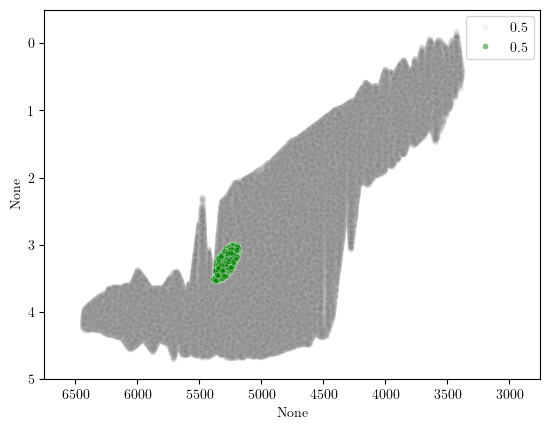

In [54]:
fig, ax = plt.subplots()
sns.scatterplot(x = eval_grid[:, teff_idx], y = eval_grid[:, logg_idx],
                 marker = "o", color = "gray", alpha = 0.1, ax = ax,
                 size = 0.5)
sns.scatterplot(x = hpd_set_2d_biased[:, 0], y = hpd_set_2d_biased[:, 1],
                 marker = "o", color = "green", alpha = 0.5, ax = ax,
                 size = 0.5)
# Axes styling
ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
ax.invert_xaxis()
ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
ax.invert_yaxis()

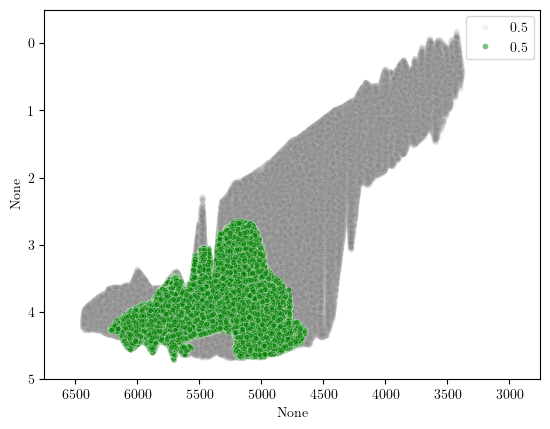

In [55]:
fig, ax = plt.subplots()
sns.scatterplot(x = eval_grid[:, teff_idx], y = eval_grid[:, logg_idx],
                 marker = "o", color = "gray", alpha = 0.1, ax = ax,
                 size = 0.5)
sns.scatterplot(x = freb_set_2d_biased[:, 0], y = freb_set_2d_biased[:, 1],
                 marker = "o", color = "green", alpha = 0.5, ax = ax,
                 size = 0.5)
# Axes styling
ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
ax.invert_xaxis()
ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
ax.invert_yaxis()

# EDA of Low Coverage

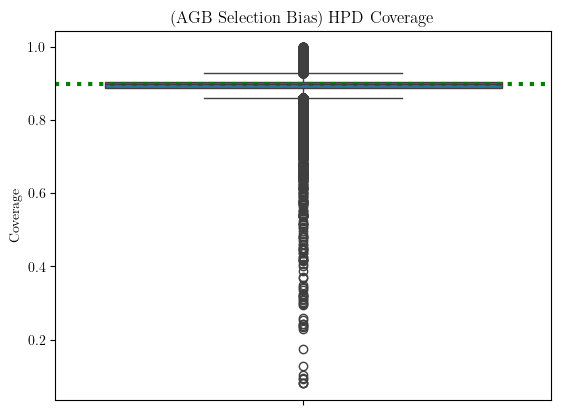

In [56]:
ax = sns.boxplot(mean_proba)
ax.axhline(0.90, color='green', linestyle='dotted', linewidth=3)

ax.set_title("(AGB Selection Bias) HPD Coverage")
ax.set_ylabel("Coverage")


plt.show()

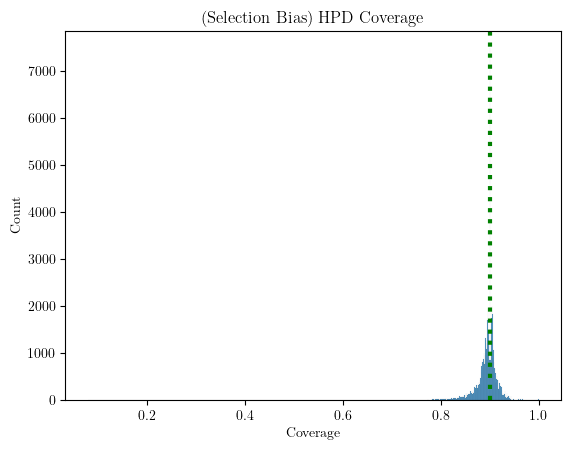

In [57]:
ax = sns.histplot(mean_proba)
ax.axvline(0.90, color='green', linestyle='dotted', linewidth=3)

ax.set_title("(Selection Bias) HPD Coverage")
ax.set_xlabel("Coverage")


plt.show()

In [58]:
coverage_data_freb_biased

,parameter1_logg,parameter2_teff,parameter3_feh,mean_proba
0,4.001568,6118.142578,-0.051728,0.909108
1,2.319799,4647.583496,-0.158625,0.901483
2,4.194684,5939.833984,-0.310649,0.922100
3,2.205735,4548.030762,-0.051108,0.888712
4,4.083413,6011.970215,0.086065,0.902400
...,...,...,...,...
60884,3.628137,5371.012695,-0.141640,0.871618
60885,2.413720,5125.012695,-0.813514,0.888204
60886,2.596135,4519.375000,0.213741,0.901225
60887,1.204939,4012.216797,-0.490944,0.903572


In [59]:
coverage_data_hpd_biased

,parameter1_logg,parameter2_teff,parameter3_feh,mean_proba
0,4.001568,6118.142578,-0.051728,0.010055
1,2.319799,4647.583496,-0.158625,0.854864
2,4.194684,5939.833984,-0.310649,0.005050
3,2.205735,4548.030762,-0.051108,0.855815
4,4.083413,6011.970215,0.086065,0.000923
...,...,...,...,...
60884,3.628137,5371.012695,-0.141640,0.043832
60885,2.413720,5125.012695,-0.813514,0.499964
60886,2.596135,4519.375000,0.213741,0.857197
60887,1.204939,4012.216797,-0.490944,0.926033


In [60]:
df = coverage_data_hpd_biased  # alias

# METALLICITY GROUPING: low < -0.5, mid [-0.5, 0.0], high > 0.0
df["metallicity_group"] = pd.cut(
    df["parameter3_feh"],
    bins=[-float("inf"), -1.5, -1, -0.75, -0.5, 0.0, 0.25, 0.4, 0.5, 0.55, float("inf")],
    labels=[r"[-inf, -1.5]", r"[-1.5, -1]", r"[-1, -0.75]", r"[-0.75, -0.5]", r"[-0.5, 0]", r"[0, 0.25]", r"[0.25, 0.4]", r"[0.4, 0.5]", r"[0.5, 0.55]", r"[0.55, inf]"]
)

# EVOLUTIONARY GROUPING (very rough cut based on logg):
# MS: logg > 3.5
# AGB: logg < 2.2
# Others: intermediate/evolved giants (optional exclusion)
# Define separation line
logg_cut = 5.9 - 0.4 * df["parameter2_teff"] / 1000
df["evolution_stage"] = np.where(df["parameter1_logg"] >= logg_cut, "MS", "AGB")

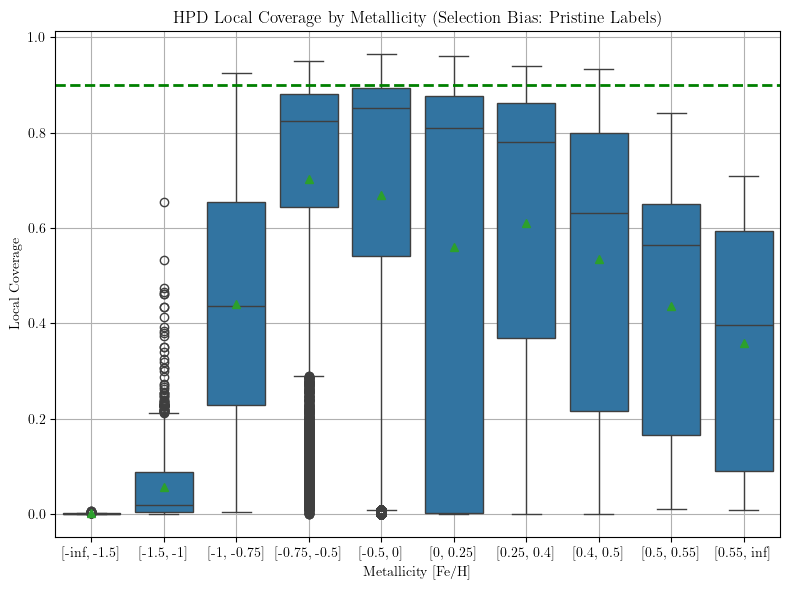

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x="metallicity_group", y="mean_proba", data=df, showmeans=True)
plt.axhline(y=0.9, color="green", linestyle="--", linewidth=2, label="Target = 0.9")
plt.xlabel("Metallicity [Fe/H]")
plt.ylabel("Local Coverage")
plt.title("HPD Local Coverage by Metallicity (Selection Bias: Pristine Labels)")
plt.grid(True)
plt.tight_layout()
plt.show()

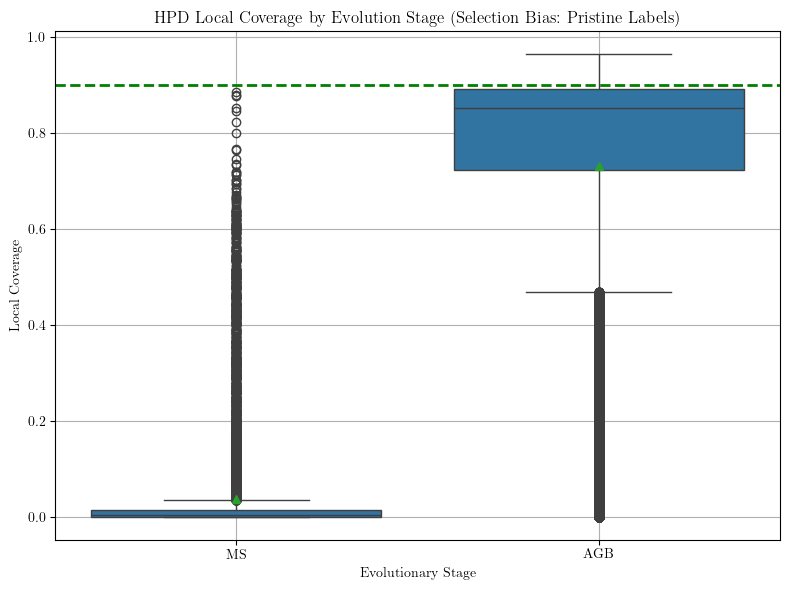

In [62]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="evolution_stage", y="mean_proba", data=df[df["evolution_stage"] != "Other"], showmeans=True)
plt.axhline(y=0.9, color="green", linestyle="--", linewidth=2, label="Target = 0.9")
plt.xlabel("Evolutionary Stage")
plt.ylabel("Local Coverage")
plt.title("HPD Local Coverage by Evolution Stage (Selection Bias: Pristine Labels)")
plt.grid(True)
plt.tight_layout()
plt.show()

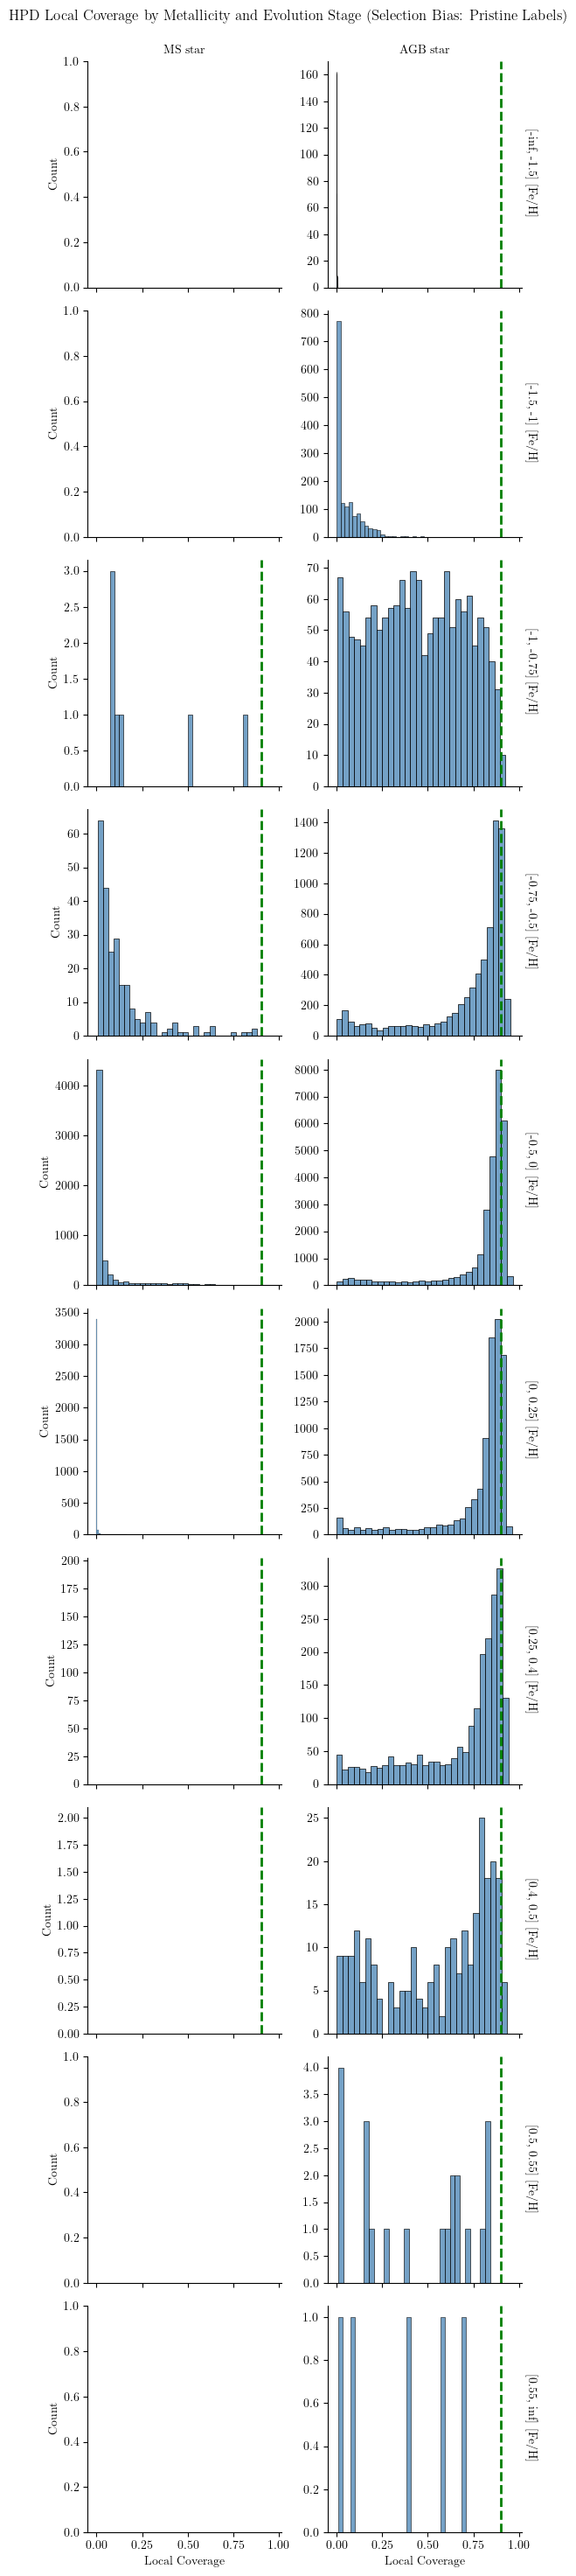

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom plotting function
def hist_with_vline(data, color, **kwargs):
    ax = plt.gca()
    sns.histplot(data["mean_proba"], bins=30, color=color, ax=ax, kde=False)
    ax.axvline(x=0.9, color="green", linestyle="--", linewidth=2, label="Target")  # example threshold
    ax.set_xlabel("Local Coverage")  # enforce x-label per panel

# Create the FacetGrid
g = sns.FacetGrid(
    df,
    row="metallicity_group",
    col="evolution_stage",
    margin_titles=True,
    height=3,
    aspect=1,
    sharey=False
)

# Map the function with vertical line
g.map_dataframe(hist_with_vline, color="steelblue")

# Add titles and axis styling
g.set_axis_labels("Local Coverage", "Count")  # y-label only here, x handled inside
g.set_titles(row_template="{row_name} [Fe/H]", col_template="{col_name} star")

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.96)
g.fig.suptitle("HPD Local Coverage by Metallicity and Evolution Stage (Selection Bias: Pristine Labels)")

plt.show()

In [64]:
df["parameter3_feh"].max()

0.8375465

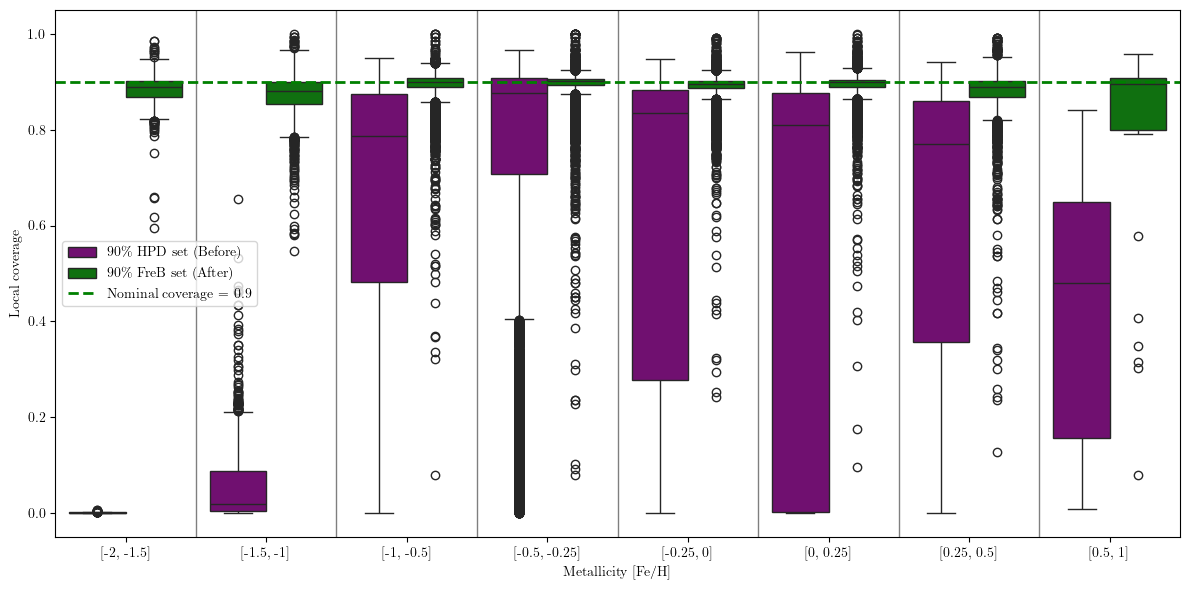

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Setup: define metallicity groups and evolutionary stages for both datasets ---

def annotate_metadata(df):
    df = df.copy()
    df["metallicity_group"] = pd.cut(
        df["parameter3_feh"],
        bins=[-2, -1.5, -1, -0.5, -0.25, 0.0, 0.25, 0.5, 1],
        labels=[
            r"[-2, -1.5]", r"[-1.5, -1]", r"[-1, -0.5]", r"[-0.5, -0.25]",
            r"[-0.25, 0]", r"[0, 0.25]", r"[0.25, 0.5]", r"[0.5, 1]"
        ]
    )
    logg_cut = 5.9 - 0.4 * df["parameter2_teff"] / 1000
    df["evolution_stage"] = np.where(df["parameter1_logg"] >= logg_cut, "MS", "AGB")
    return df

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_biased)
df_hpd["method"] = r"90\% HPD set (Before)"

df_freb = annotate_metadata(coverage_data_freb_biased)
df_freb["method"] = r"90\% FreB set (After)"

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- Plotting ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="metallicity_group",
    y="mean_proba",
    hue="method",
    data=df_combined,
    showmeans=False,
    palette={"90\\% HPD set (Before)": "purple", "90\\% FreB set (After)": "green"}
)

x_positions = ax.get_xticks()
n_groups = df_combined['metallicity_group'].nunique()
for i in range(n_groups - 1):
    line_position = i + 0.5
    plt.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.axhline(y=0.9, color="green", linestyle="--", linewidth=2, label="Nominal coverage = 0.9")
plt.xlabel("Metallicity [Fe/H]")
plt.ylabel("Local coverage")
plt.xticks(rotation=0)
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

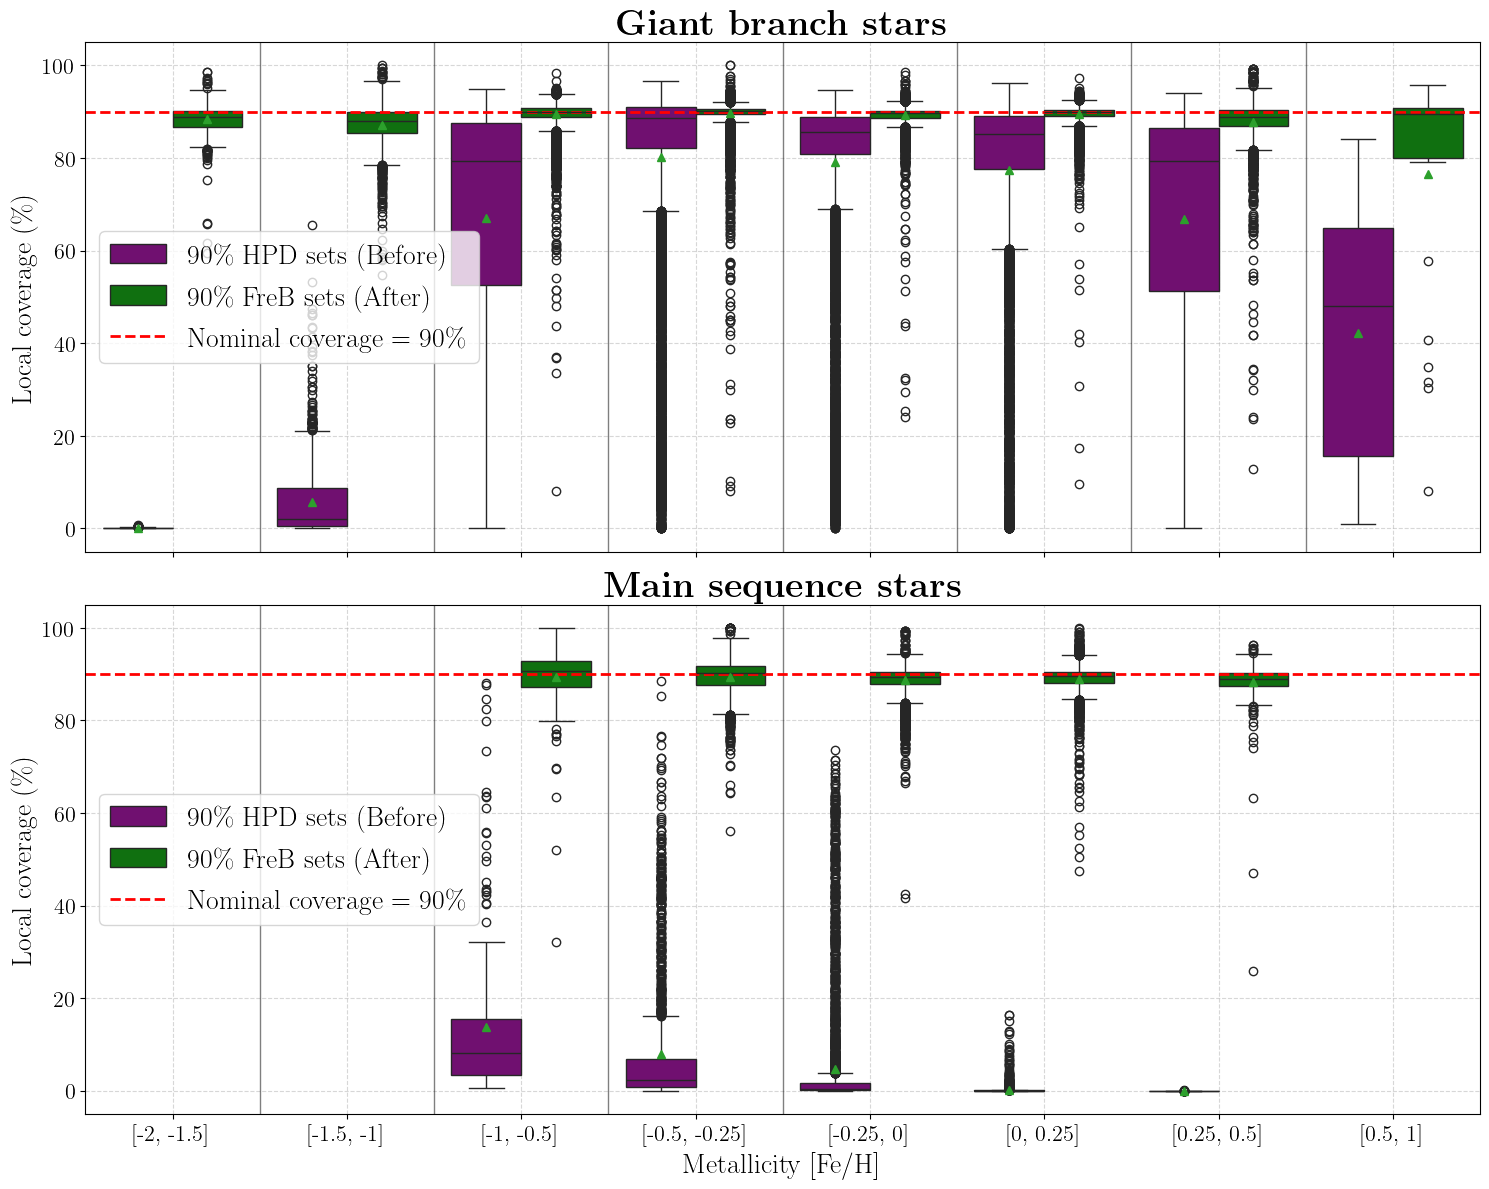

In [66]:
# Setup LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

# Create figure with subplots - 2 rows, 1 column
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_biased)
df_hpd["method"] = r"90\% HPD sets (Before)"

df_freb = annotate_metadata(coverage_data_freb_biased)
df_freb["method"] = r"90\% FreB sets (After)"

# Convert mean_proba from fractions to percentages
df_hpd["mean_proba_percent"] = df_hpd["mean_proba"] * 100
df_freb["mean_proba_percent"] = df_freb["mean_proba"] * 100

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- TOP PANEL: AGB STARS ---
# Filter for AGB stars using evolution_stage column
df_combined_agb = df_combined[df_combined['evolution_stage'] == 'AGB']

# Top plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_agb,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_top
)

# Add vertical lines for top plot
n_groups_agb = df_combined_agb['metallicity_group'].nunique()
for i in range(n_groups_agb - 1):
    line_position = i + 0.5
    ax_top.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_top.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Labels and styling for top plot
ax_top.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_top.set_title(r"\textbf{Giant branch stars}", fontsize=TITLE_FONTSIZE)
ax_top.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_top.legend(loc='center left', fontsize=LEGEND_FONTSIZE)
ax_top.grid(True, linestyle="--", alpha=0.5)
ax_top.set_xlabel("")  # Remove x-label from top plot

# --- BOTTOM PANEL: MS STARS ---
# Filter for MS stars using evolution_stage column
df_combined_ms = df_combined[df_combined['evolution_stage'] == 'MS']

# Bottom plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_ms,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_bottom
)

# Add vertical lines for bottom plot
n_groups_ms = df_combined_ms['metallicity_group'].nunique()
for i in range(n_groups_ms - 1):
    line_position = i + 0.5
    ax_bottom.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_bottom.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Labels and styling for bottom plot
ax_bottom.set_xlabel("Metallicity [Fe/H]", fontsize=LABEL_FONTSIZE)
ax_bottom.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_bottom.set_title(r"\textbf{Main sequence stars}", fontsize=TITLE_FONTSIZE)
ax_bottom.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_bottom.tick_params(axis='x', rotation=0)
ax_bottom.legend(loc='center left', fontsize=LEGEND_FONTSIZE)
ax_bottom.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()

# Save with high DPI
plt.savefig(f"{data_paths['figures']}/coverage_boxplot_metallicity_agb_ms.png", dpi=400, bbox_inches="tight", facecolor="white", edgecolor="none")
plt.show()

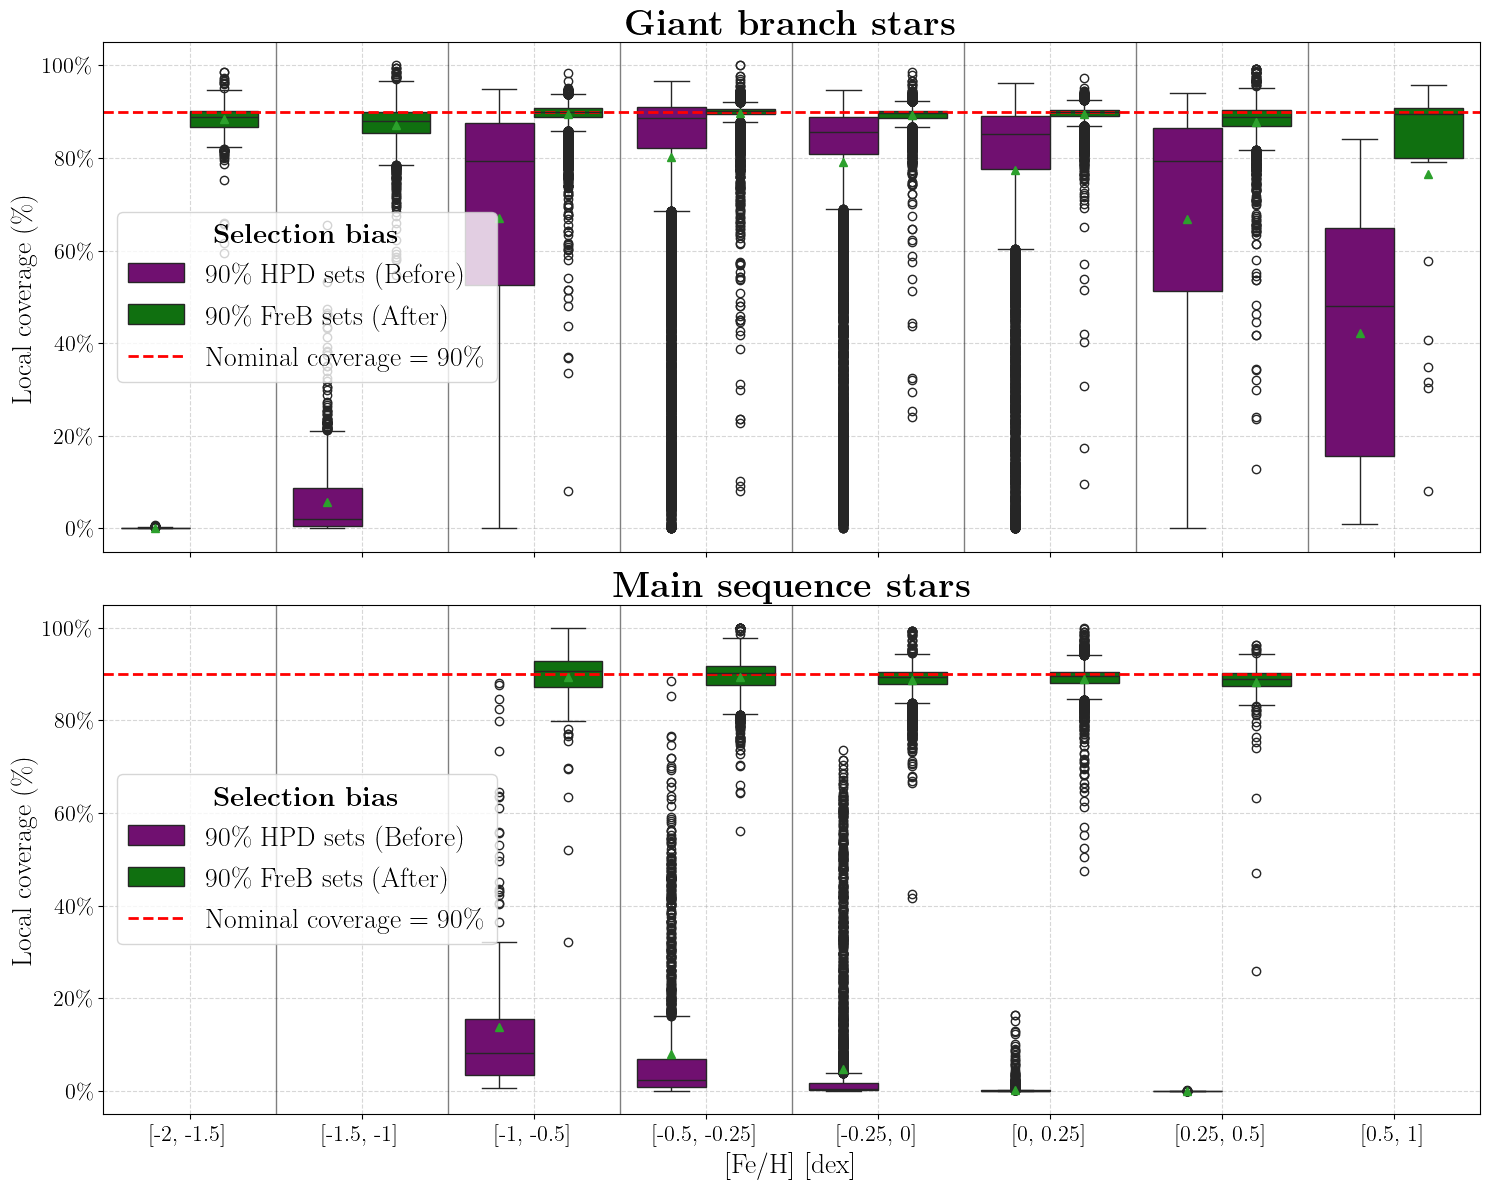

In [81]:
# Setup LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

# Create figure with subplots - 2 rows, 1 column
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_biased)
df_hpd["method"] = r"90\% HPD sets (Before)"

df_freb = annotate_metadata(coverage_data_freb_biased)
df_freb["method"] = r"90\% FreB sets (After)"

# Convert mean_proba from fractions to percentages
df_hpd["mean_proba_percent"] = df_hpd["mean_proba"] * 100
df_freb["mean_proba_percent"] = df_freb["mean_proba"] * 100

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- TOP PANEL: AGB STARS ---
# Filter for AGB stars using evolution_stage column
df_combined_agb = df_combined[df_combined['evolution_stage'] == 'AGB']

# Top plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_agb,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_top
)

# Add vertical lines for top plot
n_groups_agb = df_combined_agb['metallicity_group'].nunique()
for i in range(n_groups_agb - 1):
    line_position = i + 0.5
    ax_top.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_top.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Add % formatting to y-axis ticks for top plot
ax_top.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}\\%'))

# Labels and styling for top plot
ax_top.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_top.set_title(r"\textbf{Giant branch stars}", fontsize=TITLE_FONTSIZE)
ax_top.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_top.legend(title=r"\textbf{Selection bias}", loc='center left', fontsize=LEGEND_FONTSIZE, title_fontsize=LEGEND_FONTSIZE)
ax_top.grid(True, linestyle="--", alpha=0.5)
ax_top.set_xlabel("")  # Remove x-label from top plot

# --- BOTTOM PANEL: MS STARS ---
# Filter for MS stars using evolution_stage column
df_combined_ms = df_combined[df_combined['evolution_stage'] == 'MS']

# Bottom plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_ms,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_bottom
)

# Add vertical lines for bottom plot
n_groups_ms = df_combined_ms['metallicity_group'].nunique()
for i in range(n_groups_ms - 1):
    line_position = i + 0.5
    ax_bottom.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_bottom.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Add % formatting to y-axis ticks for bottom plot
ax_bottom.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}\\%'))

# Labels and styling for bottom plot
ax_bottom.set_xlabel("[Fe/H] [dex]", fontsize=LABEL_FONTSIZE)
ax_bottom.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_bottom.set_title(r"\textbf{Main sequence stars}", fontsize=TITLE_FONTSIZE)
ax_bottom.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_bottom.tick_params(axis='x', rotation=0)
ax_bottom.legend(title=r"\textbf{Selection bias}", loc='center left', fontsize=LEGEND_FONTSIZE, title_fontsize=LEGEND_FONTSIZE)
ax_bottom.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()

# Save with high DPI
plt.savefig(f"{data_paths['figures']}/coverage_boxplot_metallicity_agb_ms_biased.png", dpi=400, bbox_inches="tight", facecolor="white", edgecolor="none")
plt.show()

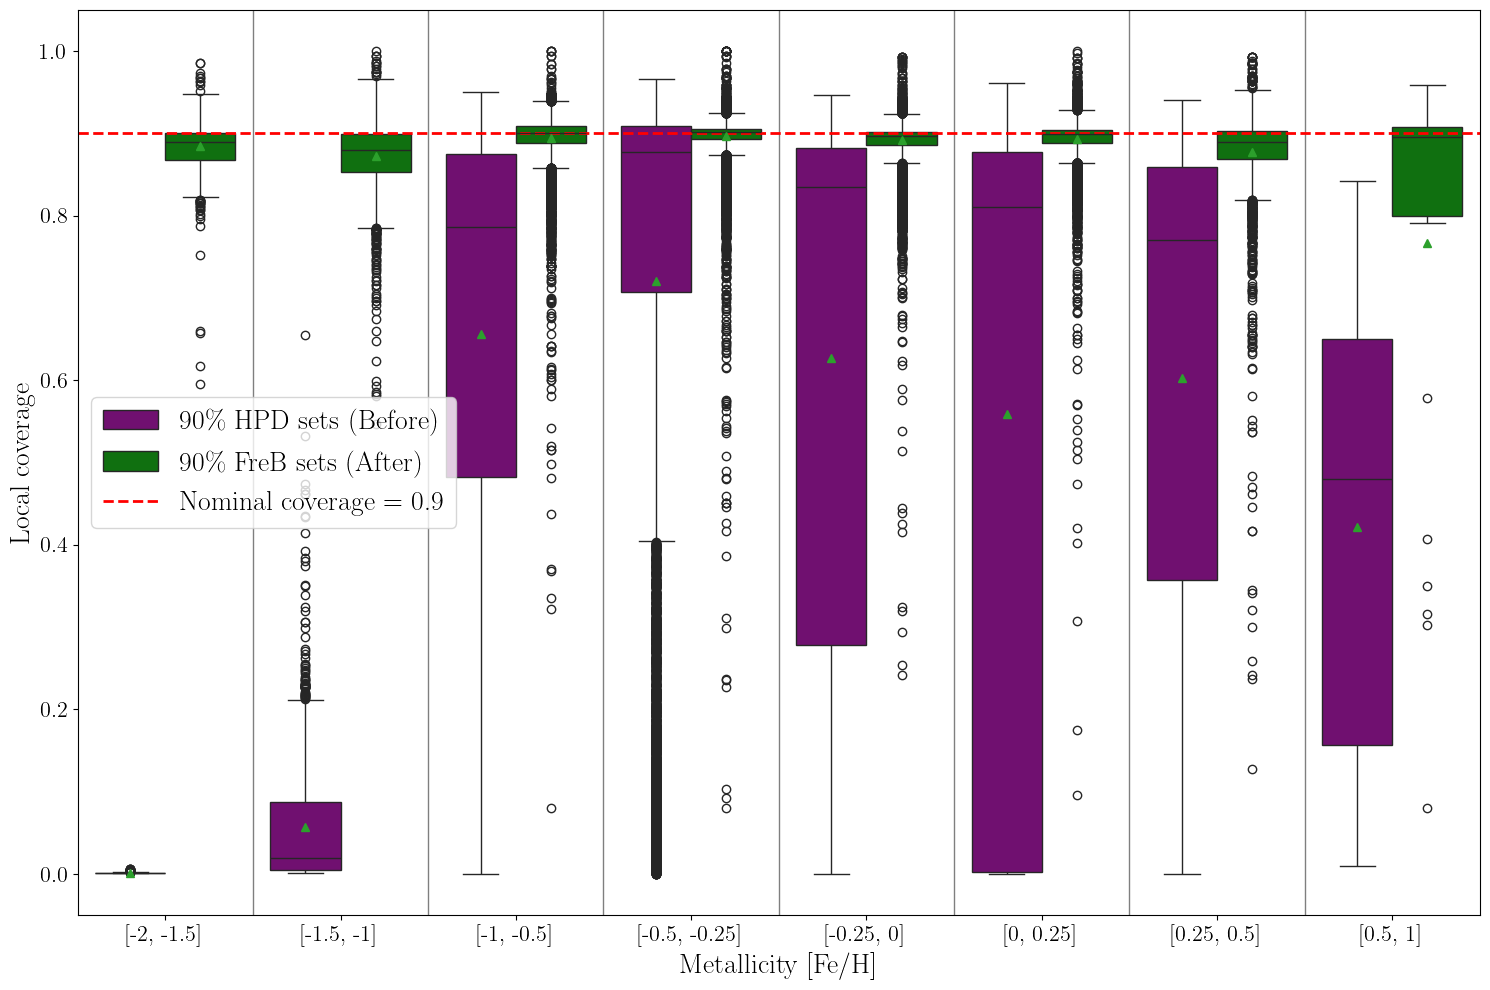

In [68]:
# Setup LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

# Figure size - adjust based on your layout needs
plt.figure(figsize=(15, 10))

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_biased)
df_hpd["method"] = r"90\% HPD sets (Before)"

df_freb = annotate_metadata(coverage_data_freb_biased)
df_freb["method"] = r"90\% FreB sets (After)"

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- Plotting ---
ax = sns.boxplot(
    x="metallicity_group",
    y="mean_proba",
    hue="method",
    data=df_combined,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"}
)

# Add vertical lines between metallicity groups
n_groups = df_combined['metallicity_group'].nunique()
for i in range(n_groups - 1):
    line_position = i + 0.5
    plt.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line
plt.axhline(y=0.9, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 0.9")

# Labels with LaTeX formatting
plt.xlabel("Metallicity [Fe/H]", fontsize=LABEL_FONTSIZE)  # Adjust fontsize to match LABEL_FONTSIZE
plt.ylabel("Local coverage", fontsize=LABEL_FONTSIZE)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)  # Adjust to match TICK_LABELSIZE
plt.xticks(rotation=0)

# Legend configuration
plt.legend(loc='center left', fontsize=LEGEND_FONTSIZE)  # Adjust to match LEGEND_FONTSIZE

# Title if needed (optional)
# plt.title(r"\textbf{Coverage by Metallicity}", fontsize=16)  # Adjust to match TITLE_FONTSIZE

plt.tight_layout()
plt.savefig(f"{data_paths['figures']}/coverage_boxplot_metallicity.png", dpi=400, bbox_inches="tight", facecolor="white", edgecolor="none")

# Save with high DPI
# plt.savefig("coverage_boxplot.png", dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none")
plt.show()


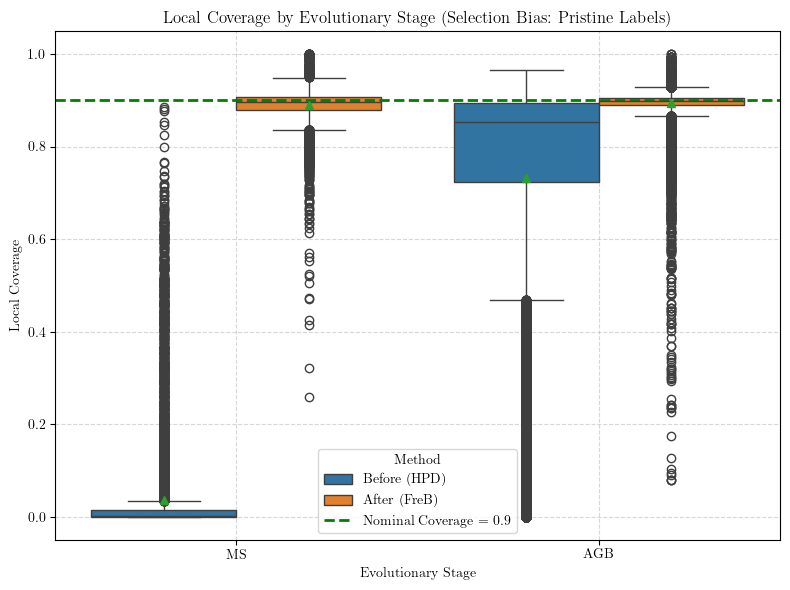

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Reuse metadata annotation function from previous step ---
def annotate_metadata(df):
    df = df.copy()
    df["metallicity_group"] = pd.cut(
        df["parameter3_feh"],
        bins=[-float("inf"), -1.5, -1, -0.75, -0.5, 0.0, 0.25, 0.4, 0.5, 0.55, float("inf")],
        labels=[
            r"[-inf, -1.5]", r"[-1.5, -1]", r"[-1, -0.75]", r"[-0.75, -0.5]",
            r"[-0.5, 0]", r"[0, 0.25]", r"[0.25, 0.4]", r"[0.4, 0.5]", r"[0.5, 0.55]", r"[0.55, inf]"
        ]
    )
    logg_cut = 5.9 - 0.4 * df["parameter2_teff"] / 1000
    df["evolution_stage"] = np.where(df["parameter1_logg"] >= logg_cut, "MS", "AGB")
    return df

# Annotate both datasets and label by method
df_hpd = annotate_metadata(coverage_data_hpd_biased)
df_hpd["method"] = "Before (HPD)"

df_freb = annotate_metadata(coverage_data_freb_biased)
df_freb["method"] = "After (FreB)"

# Combine and filter only MS and AGB
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)
df_combined = df_combined[df_combined["evolution_stage"].isin(["MS", "AGB"])]

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="evolution_stage",
    y="mean_proba",
    hue="method",
    data=df_combined,
    showmeans=True
)
plt.axhline(y=0.9, color="green", linestyle="--", linewidth=2, label="Nominal Coverage = 0.9")
plt.xlabel("Evolutionary Stage")
plt.ylabel("Local Coverage")
plt.title("Local Coverage by Evolutionary Stage (Selection Bias: Pristine Labels)")
plt.legend(title="Method")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [70]:
catalog_holdouts[0][2]

6000.0347

In [71]:
IDX_TEMP = 7
print(f"Holdout IDX: {IDX_TEMP}")
print(f"Log g: {catalog_holdouts[IDX_TEMP][1]}")
print(f"T_eff: {catalog_holdouts[IDX_TEMP][2]}")
print(f"Fe/H: {catalog_holdouts[IDX_TEMP][3]}")

Holdout IDX: 7
Log g: 4.262605667114258
T_eff: 5772.28369140625
Fe/H: -0.019717669114470482


In [72]:
# ESTIMATED COVERAGE AT EXAMPLE POINT
print(f"HPD Local Coverage (No Selection Bias): {hpd_set_2d_unbiased_est_coverage}")
print(f"FreB Local Coverage (No Selection Bias): {freb_set_2d_unbiased_est_coverage}")
print(f"HPD Local Coverage (Selection Bias): {hpd_set_2d_biased_est_coverage}")
print(f"FreB Local Coverage (Selection Bias): {freb_set_2d_biased_est_coverage}")

HPD Local Coverage (No Selection Bias): 0.8547417028967975
FreB Local Coverage (No Selection Bias): 0.8851308993446863
HPD Local Coverage (Selection Bias): 0.0012624525299084707
FreB Local Coverage (Selection Bias): 0.9011909110314509


In [73]:
# plot_kiel_diagram()
# Full Catalog
data_paths = setup_paths(notebook=True)
catalog_path = os.path.join(data_paths["data"], "xp_apogee_cat.h5")
catalog = read_catalog(catalog_path, filter="good", normalize=False)

In [74]:
# import matplotlib.pyplot as plt
# import numpy as np

# # === Configuration ===
# SUBSET_CATALOG = True
# SUBSET_N = 2000  # Adjust based on performance
# SEED = 42

# # Paths
# data_paths = setup_paths(notebook=True)
# catalog_path = os.path.join(data_paths["data"], "xp_apogee_cat.h5")

# # Quality levels and titles
# quality_levels = ["pristine", "good", "full"]
# titles = [
#     r"\textbf{Pristine Quality (Most Selective)}",
#     r"\textbf{Good Quality (Moderate Cut)}",
#     r"\textbf{Full Catalog (No Selection)}"
# ]

# # Set up figure
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 36), sharex=True, sharey=True)

# # Loop over quality levels
# for ax, quality, title in zip(axes, quality_levels, titles):
#     catalog = read_catalog(catalog_path, filter=quality, normalize=False)

#     # Subset catalog if enabled
#     if SUBSET_CATALOG:
#         rng = np.random.default_rng(SEED)
#         catalog_length = len(catalog)
#         subset_idx = rng.choice(catalog_length, size=min(SUBSET_N, catalog_length), replace=False)
#         catalog = catalog[subset_idx]

#     # Extract stellar parameters
#     teff = catalog["TEFF"]
#     logg = catalog["LOGG"]

#     # Plot Kiel diagram
#     plot_kiel_diagram(
#         target_x=teff,
#         target_y=logg,
#         ax=ax,
#         title=title,
#         plot_prior=False  # Set to True and pass prior_x/y if desired
#     )

# plt.tight_layout()
# plt.show()

In [75]:
# import matplotlib.pyplot as plt
# import numpy as np

# # === Configuration ===
# SUBSET_CATALOG = True
# SUBSET_N = 2000  # Adjust based on performance
# SEED = 42

# # Paths
# data_paths = setup_paths(notebook=True)
# catalog_path = os.path.join(data_paths["data"], "xp_apogee_cat.h5")

# # Quality levels and titles
# quality_levels = ["pristine", "good", "full"]
# titles = [
#     r"\textbf{Pristine Quality (Most Selective)}",
#     r"\textbf{Good Quality (Moderate Cut)}",
#     r"\textbf{Full Catalog (No Selection)}"
# ]

# # Set up figure
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 36), sharex=True, sharey=True)

# # Loop over quality levels
# for ax, quality, title in zip(axes, quality_levels, titles):
#     catalog = read_catalog(catalog_path, filter=quality, normalize=False)

#     # Subset catalog if enabled
#     if SUBSET_CATALOG:
#         rng = np.random.default_rng(SEED)
#         catalog_length = len(catalog)
#         subset_idx = rng.choice(catalog_length, size=min(SUBSET_N, catalog_length), replace=False)
#         catalog = catalog[subset_idx]

#     # Extract stellar parameters
#     teff = catalog["TEFF"]
#     logg = catalog["LOGG"]

#     # Plot Kiel diagram
#     plot_kiel_diagram(
#         target_x=teff,
#         target_y=logg,
#         ax=ax,
#         title=title,
#         plot_prior=False  # Set to True and pass prior_x/y if desired
#     )

# plt.tight_layout()
# plt.show()

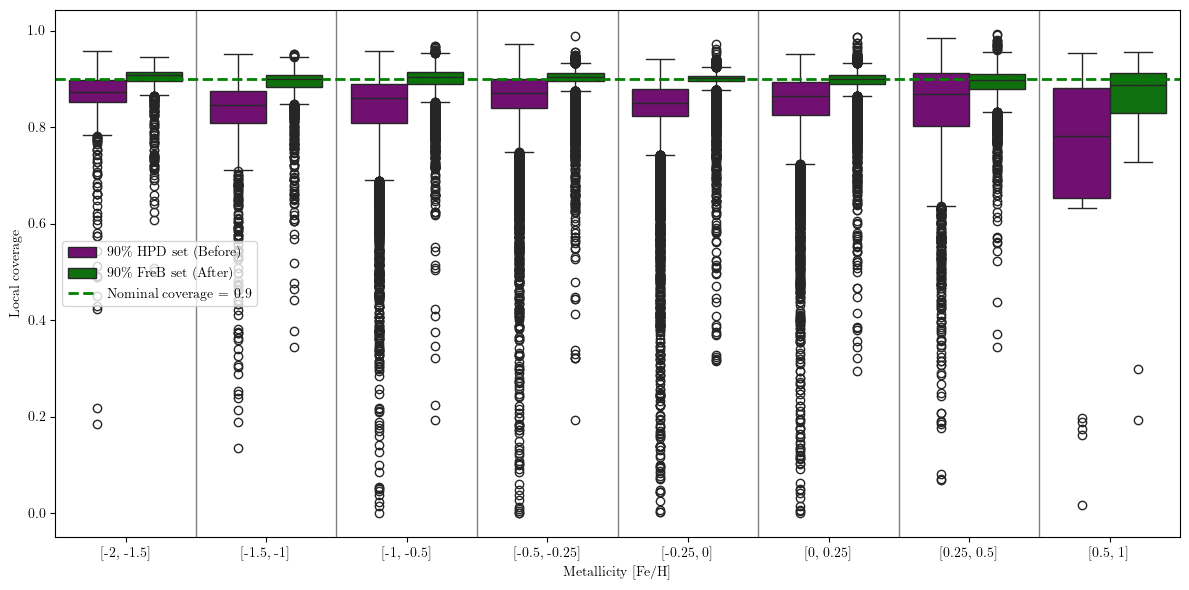

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Setup: define metallicity groups and evolutionary stages for both datasets ---

def annotate_metadata(df):
    df = df.copy()
    df["metallicity_group"] = pd.cut(
        df["parameter3_feh"],
        bins=[-2, -1.5, -1, -0.5, -0.25, 0.0, 0.25, 0.5, 1],
        labels=[
            r"[-2, -1.5]", r"[-1.5, -1]", r"[-1, -0.5]", r"[-0.5, -0.25]",
            r"[-0.25, 0]", r"[0, 0.25]", r"[0.25, 0.5]", r"[0.5, 1]"
        ]
    )
    logg_cut = 5.9 - 0.4 * df["parameter2_teff"] / 1000
    df["evolution_stage"] = np.where(df["parameter1_logg"] >= logg_cut, "MS", "AGB")
    return df

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_unbiased)
df_hpd["method"] = r"90\% HPD set (Before)"

df_freb = annotate_metadata(coverage_data_freb_unbiased)
df_freb["method"] = r"90\% FreB set (After)"

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- Plotting ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="metallicity_group",
    y="mean_proba",
    hue="method",
    data=df_combined,
    showmeans=False,
    palette={"90\\% HPD set (Before)": "purple", "90\\% FreB set (After)": "green"}
)

x_positions = ax.get_xticks()
n_groups = df_combined['metallicity_group'].nunique()
for i in range(n_groups - 1):
    line_position = i + 0.5
    plt.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.axhline(y=0.9, color="green", linestyle="--", linewidth=2, label="Nominal coverage = 0.9")
plt.xlabel("Metallicity [Fe/H]")
plt.ylabel("Local coverage")
plt.xticks(rotation=0)
plt.legend(loc='center left')
plt.tight_layout()
plt.show()

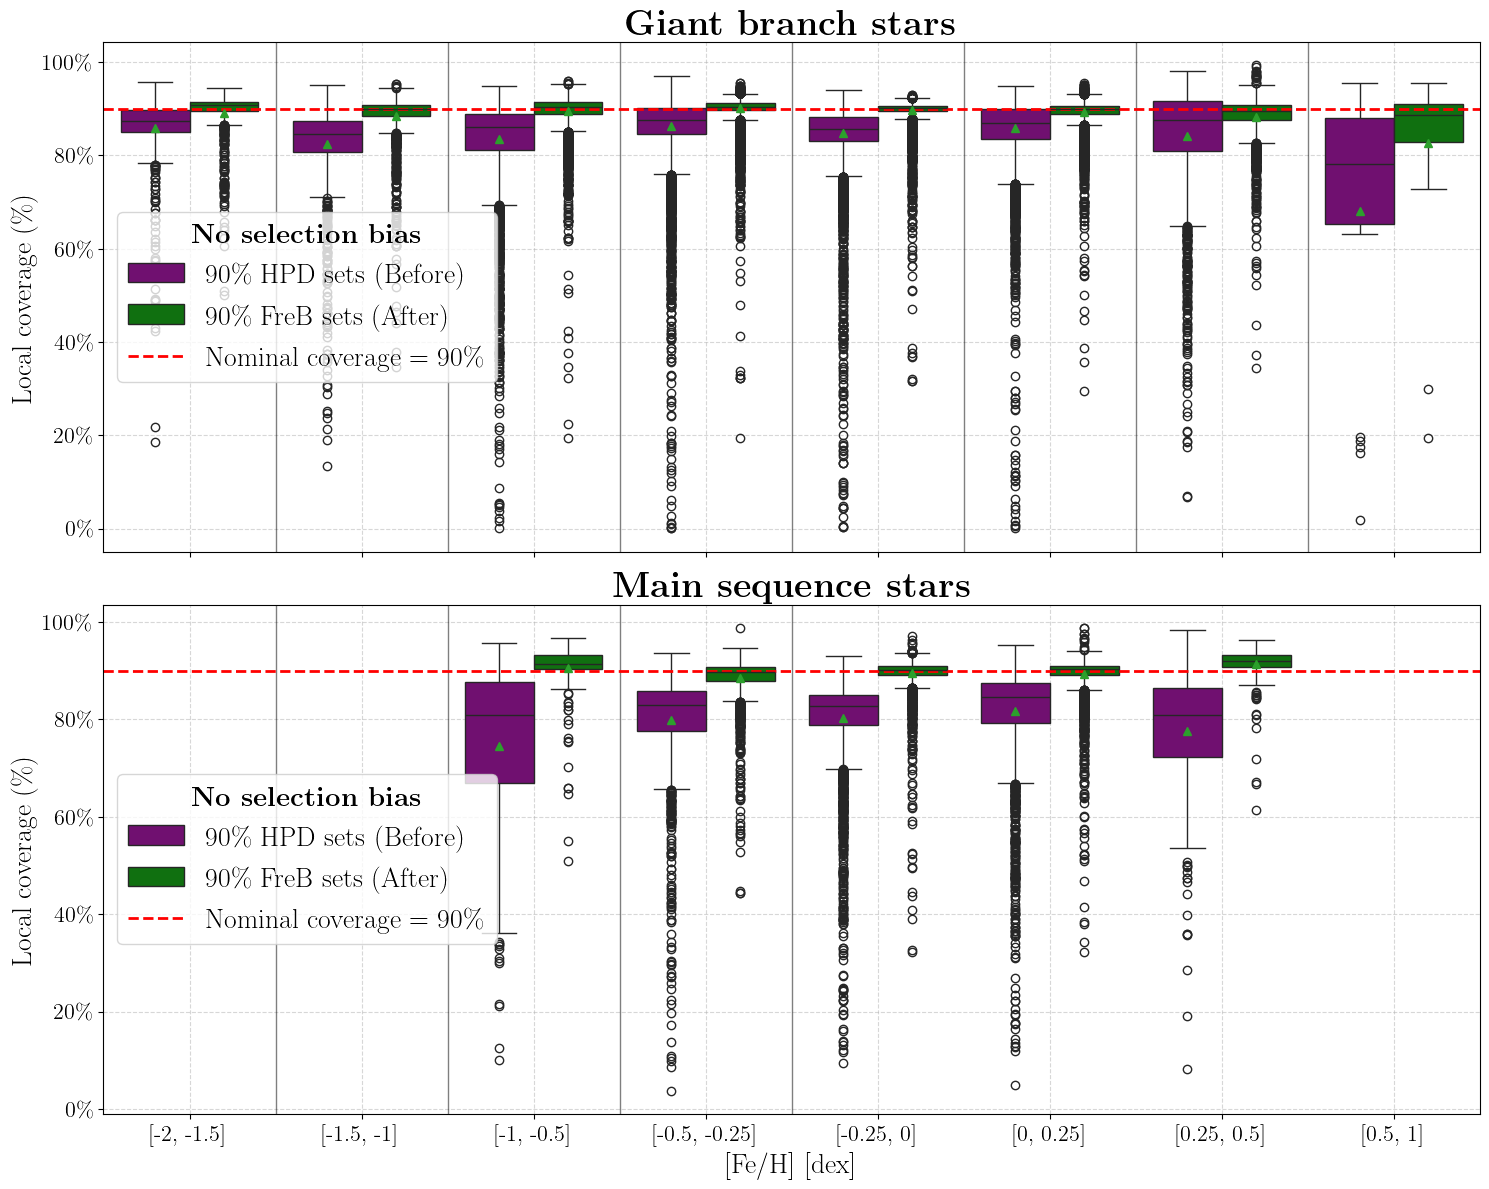

In [82]:
# Setup LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

# Create figure with subplots - 2 rows, 1 column
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Annotate both datasets
df_hpd = annotate_metadata(coverage_data_hpd_unbiased)
df_hpd["method"] = r"90\% HPD sets (Before)"

df_freb = annotate_metadata(coverage_data_freb_unbiased)
df_freb["method"] = r"90\% FreB sets (After)"

# Convert mean_proba from fractions to percentages
df_hpd["mean_proba_percent"] = df_hpd["mean_proba"] * 100
df_freb["mean_proba_percent"] = df_freb["mean_proba"] * 100

# --- Combine for side-by-side plotting ---
df_combined = pd.concat([df_hpd, df_freb], ignore_index=True)

# --- TOP PANEL: AGB STARS ---
# Filter for AGB stars using evolution_stage column
df_combined_agb = df_combined[df_combined['evolution_stage'] == 'AGB']

# Top plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_agb,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_top
)

# Add vertical lines for top plot
n_groups_agb = df_combined_agb['metallicity_group'].nunique()
for i in range(n_groups_agb - 1):
    line_position = i + 0.5
    ax_top.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_top.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Add % formatting to y-axis ticks for top plot
ax_top.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}\\%'))

# Labels and styling for top plot
ax_top.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_top.set_title(r"\textbf{Giant branch stars}", fontsize=TITLE_FONTSIZE)
ax_top.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_top.legend(title=r"\textbf{No selection bias}", loc='center left', fontsize=LEGEND_FONTSIZE, title_fontsize=LEGEND_FONTSIZE)
ax_top.grid(True, linestyle="--", alpha=0.5)
ax_top.set_xlabel("")  # Remove x-label from top plot

# --- BOTTOM PANEL: MS STARS ---
# Filter for MS stars using evolution_stage column
df_combined_ms = df_combined[df_combined['evolution_stage'] == 'MS']

# Bottom plot
sns.boxplot(
    x="metallicity_group",
    y="mean_proba_percent",
    hue="method",
    data=df_combined_ms,
    showmeans=True,
    palette={"90\\% HPD sets (Before)": "purple", "90\\% FreB sets (After)": "green"},
    ax=ax_bottom
)

# Add vertical lines for bottom plot
n_groups_ms = df_combined_ms['metallicity_group'].nunique()
for i in range(n_groups_ms - 1):
    line_position = i + 0.5
    ax_bottom.axvline(x=line_position, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add horizontal reference line at 90%
ax_bottom.axhline(y=90, color="red", linestyle="--", linewidth=2, label="Nominal coverage = 90\\%")

# Add % formatting to y-axis ticks for bottom plot
ax_bottom.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}\\%'))

# Labels and styling for bottom plot
ax_bottom.set_xlabel("[Fe/H] [dex]", fontsize=LABEL_FONTSIZE)
ax_bottom.set_ylabel("Local coverage (\\%)", fontsize=LABEL_FONTSIZE)
ax_bottom.set_title(r"\textbf{Main sequence stars}", fontsize=TITLE_FONTSIZE)
ax_bottom.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
ax_bottom.tick_params(axis='x', rotation=0)
ax_bottom.legend(title=r"\textbf{No selection bias}", loc='center left', fontsize=LEGEND_FONTSIZE, title_fontsize=LEGEND_FONTSIZE)
ax_bottom.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()

# Save with high DPI
plt.savefig(f"{data_paths['figures']}/coverage_boxplot_metallicity_agb_ms_unbiased.png", dpi=400, bbox_inches="tight", facecolor="white", edgecolor="none")
plt.show()

# TABLE 1 FIGURE

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


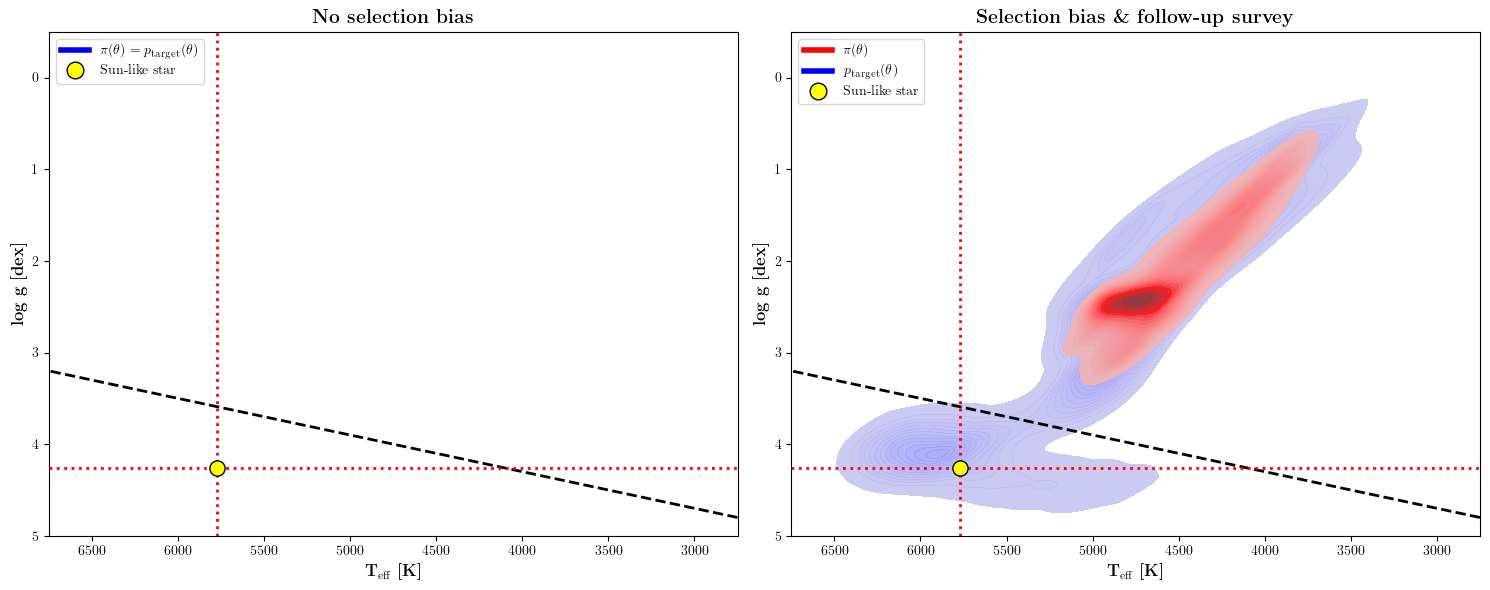

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


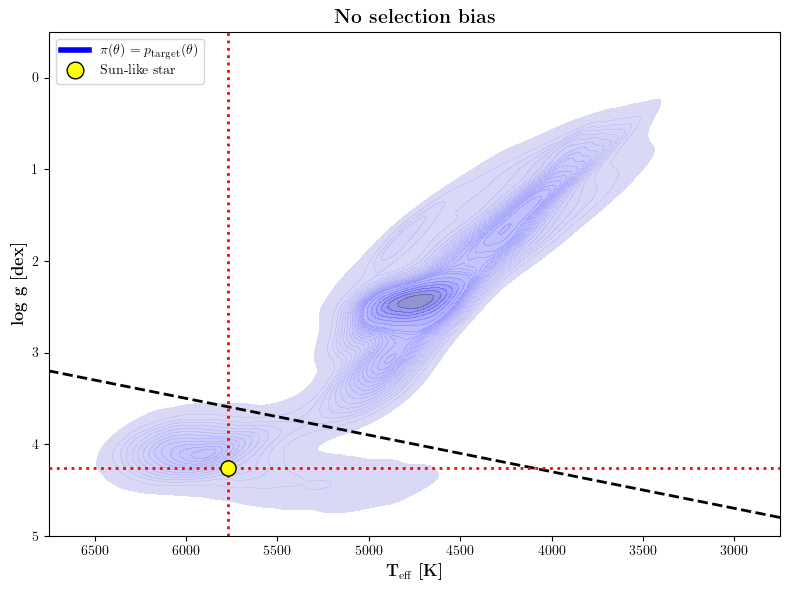

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


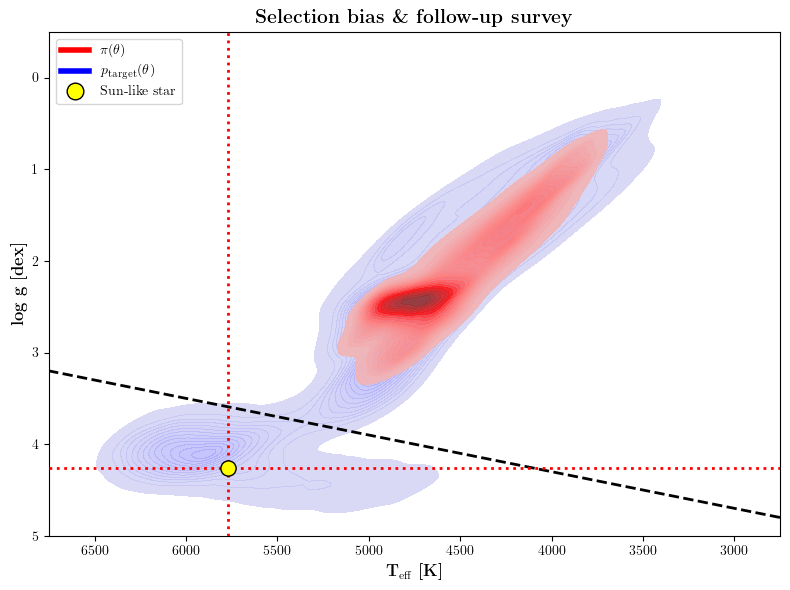

In [84]:
import matplotlib.pyplot as plt

# Setup LaTeX rendering (from your original code)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'''
     \usepackage{amsmath}
     \usepackage{amssymb}
     \usepackage{bm}
     \usepackage{underscore}
 '''

# # Create figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot 1: Good Catalog (Unbiased Setting) - NO PRIOR
# plot_kiel_diagram(
#     target_x=catalog["TEFF"], # teff
#     target_y=catalog["LOGG"], # logg
#     prior_x=None,
#     prior_y=None,
#     ax=ax1,
#     title=NO_BIAS_KIEL_TITLE,
#     xlabel=KIEL_XLABEL,
#     ylabel=KIEL_YLABEL,
#     target_color=TARGET_COLOR,
#     target_alpha=TARGET_ALPHA,
#     target_label=NO_BIAS_KIEL_TARGET_LEGEND_LABEL,
#     target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
#     plot_prior=False,
#     prior_filter=PRIOR_FILTER,
#     prior_color=PRIOR_COLOR,
#     prior_alpha=PRIOR_ALPHA,
#     prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
#     prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
#     separation_line_color=SEPARATION_LINE_COLOR,
#     separation_line_style=SEPARATION_LINE_STYLE,
#     separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
#     kde_levels=KDE_LEVELS,
#     kde_thresh=KDE_THRESH,
#     kde_linewidths=KDE_LINEWIDTHS,
#     plot_reference_star=True,
#     reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
#     reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
#     reference_star_marker=REFERENCE_STAR_MARKER,
#     reference_star_color=REFERENCE_STAR_COLOR,
#     reference_star_size=REFERENCE_STAR_SIZE,
#     reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
#     reference_star_label=REFERENCE_STAR_LABEL,
#     reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
#     crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
#     crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
#     crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
#     kiel_xlim_low=KIEL_XLIM_LOW,
#     kiel_xlim_high=KIEL_XLIM_HIGH,
#     kiel_ylim_low=KIEL_YLIM_LOW,
#     kiel_ylim_high=KIEL_YLIM_HIGH,
#     title_fontsize=TITLE_FONTSIZE,
#     label_fontsize=LABEL_FONTSIZE,
#     tick_labelsize=TICK_LABELSIZE,
#     legend_fontsize=LEGEND_FONTSIZE,
#     legend_location=KIEL_LEGEND_LOCATION,
#     figsize_x=SUBPLOT_FIGSIZE_X,
#     figsize_y=SUBPLOT_FIGSIZE_Y
# )

# # Plot 2: Pristine Catalog/Prior (Biased Setting) - WITH PRIOR
# plot_kiel_diagram(
#     target_x=catalog["TEFF"], # teff
#     target_y=catalog["LOGG"], # logg
#     prior_x=teff_train_biased,
#     prior_y=logg_train_biased,
#     ax=ax2,
#     title=SELECTION_BIAS_KIEL_TITLE,
#     xlabel=KIEL_XLABEL,
#     ylabel=KIEL_YLABEL,
#     target_color=TARGET_COLOR,
#     target_alpha=TARGET_ALPHA,
#     target_label=SELECTION_BIAS_KIEL_TARGET_LEGEND_LABEL,
#     target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
#     plot_prior=True,
#     prior_filter=PRIOR_FILTER,
#     prior_color=PRIOR_COLOR,
#     prior_alpha=PRIOR_ALPHA + 0.5,
#     prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
#     prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
#     separation_line_color=SEPARATION_LINE_COLOR,
#     separation_line_style=SEPARATION_LINE_STYLE,
#     separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
#     kde_levels=KDE_LEVELS,
#     kde_thresh=KDE_THRESH,
#     kde_linewidths=KDE_LINEWIDTHS,
#     plot_reference_star=True,
#     reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
#     reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
#     reference_star_marker=REFERENCE_STAR_MARKER,
#     reference_star_color=REFERENCE_STAR_COLOR,
#     reference_star_size=REFERENCE_STAR_SIZE,
#     reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
#     reference_star_label=REFERENCE_STAR_LABEL,
#     reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
#     crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
#     crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
#     crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
#     kiel_xlim_low=KIEL_XLIM_LOW,
#     kiel_xlim_high=KIEL_XLIM_HIGH,
#     kiel_ylim_low=KIEL_YLIM_LOW,
#     kiel_ylim_high=KIEL_YLIM_HIGH,
#     title_fontsize=TITLE_FONTSIZE,
#     label_fontsize=LABEL_FONTSIZE,
#     tick_labelsize=TICK_LABELSIZE,
#     legend_fontsize=LEGEND_FONTSIZE,
#     legend_location=KIEL_LEGEND_LOCATION,
#     figsize_x=SUBPLOT_FIGSIZE_X,
#     figsize_y=SUBPLOT_FIGSIZE_Y
# )

# plt.tight_layout()
# plt.show()

# If you want individual plots, save them separately:
# Plot 1 only - Good Catalog
fig1, ax = plt.subplots(figsize=(8, 6))
plot_kiel_diagram(
    target_x=catalog["TEFF"],
    target_y=catalog["LOGG"],
    prior_x=None,
    prior_y=None,
    ax=ax,
    title=NO_BIAS_KIEL_TITLE,
    xlabel=KIEL_XLABEL,
    ylabel=KIEL_YLABEL,
    target_color=TARGET_COLOR,
    target_alpha=TARGET_ALPHA,
    target_label=NO_BIAS_KIEL_TARGET_LEGEND_LABEL,
    target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
    plot_prior=False,
    prior_filter=PRIOR_FILTER,
    prior_color=PRIOR_COLOR,
    prior_alpha=PRIOR_ALPHA,
    prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
    prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
    separation_line_color=SEPARATION_LINE_COLOR,
    separation_line_style=SEPARATION_LINE_STYLE,
    separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
    kde_levels=KDE_LEVELS,
    kde_thresh=KDE_THRESH,
    kde_linewidths=KDE_LINEWIDTHS,
    plot_reference_star=True,
    reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
    reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
    reference_star_marker=REFERENCE_STAR_MARKER,
    reference_star_color=REFERENCE_STAR_COLOR,
    reference_star_size=REFERENCE_STAR_SIZE,
    reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
    reference_star_label=REFERENCE_STAR_LABEL,
    reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
    crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
    crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
    crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
    kiel_xlim_low=KIEL_XLIM_LOW,
    kiel_xlim_high=KIEL_XLIM_HIGH,
    kiel_ylim_low=KIEL_YLIM_LOW,
    kiel_ylim_high=KIEL_YLIM_HIGH,
    title_fontsize=TITLE_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
    tick_labelsize=TICK_LABELSIZE,
    legend_fontsize=LEGEND_FONTSIZE,
    legend_location=KIEL_LEGEND_LOCATION,
    figsize_x=SUBPLOT_FIGSIZE_X,
    figsize_y=SUBPLOT_FIGSIZE_Y
)
plt.tight_layout()
plt.savefig('kiel_diagram_good_catalog.png', dpi=400, bbox_inches='tight')
plt.show()

# Plot 2 only - Pristine Catalog/Prior
fig2, ax = plt.subplots(figsize=(8, 6))
plot_kiel_diagram(
    target_x=catalog["TEFF"],
    target_y=catalog["LOGG"],
    prior_x=teff_train_biased,
    prior_y=logg_train_biased,
    ax=ax,
    title=SELECTION_BIAS_KIEL_TITLE,
    xlabel=KIEL_XLABEL,
    ylabel=KIEL_YLABEL,
    target_color=TARGET_COLOR,
    target_alpha=TARGET_ALPHA,
    target_label=SELECTION_BIAS_KIEL_TARGET_LEGEND_LABEL,
    target_label_linewidth=KIEL_LEGEND_LINEWIDTH,
    plot_prior=True,
    prior_filter=PRIOR_FILTER,
    prior_color=PRIOR_COLOR,
    prior_alpha=PRIOR_ALPHA + 0.5,
    prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
    prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
    separation_line_color=SEPARATION_LINE_COLOR,
    separation_line_style=SEPARATION_LINE_STYLE,
    separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
    kde_levels=KDE_LEVELS,
    kde_thresh=KDE_THRESH,
    kde_linewidths=KDE_LINEWIDTHS,
    plot_reference_star=True,
    reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
    reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
    reference_star_marker=REFERENCE_STAR_MARKER,
    reference_star_color=REFERENCE_STAR_COLOR,
    reference_star_size=REFERENCE_STAR_SIZE,
    reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
    reference_star_label=REFERENCE_STAR_LABEL,
    reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
    crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
    crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
    crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
    kiel_xlim_low=KIEL_XLIM_LOW,
    kiel_xlim_high=KIEL_XLIM_HIGH,
    kiel_ylim_low=KIEL_YLIM_LOW,
    kiel_ylim_high=KIEL_YLIM_HIGH,
    title_fontsize=TITLE_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
    tick_labelsize=TICK_LABELSIZE,
    legend_fontsize=LEGEND_FONTSIZE,
    legend_location=KIEL_LEGEND_LOCATION,
    figsize_x=SUBPLOT_FIGSIZE_X,
    figsize_y=SUBPLOT_FIGSIZE_Y
)
plt.tight_layout()
plt.savefig('kiel_diagram_pristine_catalog.png', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
def plot_kiel_diagram(
        target_x, # teff
        target_y, # logg
        prior_x=None,
        prior_y=None,
        ax=None,
        title=r"\textbf{No Selection Bias}",
        xlabel=r"\textbf{T}$\mathbf{_{\mathrm{eff}}}$ \textbf{(K)}",
        ylabel=r"\textbf{log }$\mathbf{g}$ \textbf{(dex)}",
        target_color="gray",
        target_alpha=0.25,
        target_label=r"$p_{\mathrm{target}}(\theta)$",
        target_label_linewidth=4,
        plot_prior=False,
        prior_filter=True,
        prior_color="blue",
        prior_alpha=0.25,
        prior_label=r"$\pi(\theta)$",
        prior_label_linewidth=4,
        separation_line_color="black",
        separation_line_style="--",
        separation_line_linewidth=2,
        kde_levels=25,
        kde_thresh=0.01,
        kde_linewidths=2,
        plot_reference_star=True,
        reference_star_teff=4750,
        reference_star_logg=4.5,
        reference_star_marker="*",
        reference_star_color="red",
        reference_star_size=400,
        reference_star_edgecolor="black",
        reference_star_label="Reference Star",
        reference_star_legend_size=15,
        crosshair_style=":",
        crosshair_color="red",
        crosshair_linewidth=2,
        kiel_xlim_low=2750,
        kiel_xlim_high=6750,
        kiel_ylim_low=-0.5,
        kiel_ylim_high=5,
        title_fontsize=36,
        label_fontsize=20,
        tick_labelsize=16,
        legend_fontsize=16,
        legend_location="upper left",
        figsize_x=15,
        figsize_y=12
):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Target Distribution (full data region/parameter space)
    sns.kdeplot(x=target_x,
                y=target_y,
                fill = True,
                color=target_color,
                alpha=target_alpha,
                thresh=kde_thresh,
                levels=kde_levels,
                linewidths=kde_linewidths,
                zorder=1)
    
    # Prior Distribution (train data)
    if plot_prior:
        if prior_filter:
            separation_logg = 5.9 - 0.4 * prior_x / 1000
            mask = prior_y < separation_logg
            prior_x = prior_x[mask]
            prior_y = prior_y[mask]

        if len(prior_x) > 0:
            sns.kdeplot(x=prior_x,
                        y=prior_y,
                        fill = True,
                        color=prior_color,
                        alpha=prior_alpha,
                        thresh=kde_thresh,
                        levels=kde_levels,
                        linewidths=kde_linewidths,
                        zorder=2)

    # Reference Star Marker and Crosshair
    if plot_reference_star:
        ax.axhline(reference_star_logg,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.axvline(reference_star_teff,
                   ls=crosshair_style,
                   color=crosshair_color,
                   lw=crosshair_linewidth,
                   zorder=4)
        ax.scatter([reference_star_teff],
                   [reference_star_logg],
                   marker=reference_star_marker,
                   s=reference_star_size,
                   color=reference_star_color,
                   edgecolor=reference_star_edgecolor,
                   zorder=5)
        
    # Axes styling
    ax.set_xlim(kiel_xlim_low, kiel_xlim_high)
    ax.invert_xaxis()
    ax.set_ylim(kiel_ylim_low, kiel_ylim_high)
    ax.invert_yaxis()
    ax.tick_params(labelsize=tick_labelsize)

    # Title and Labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


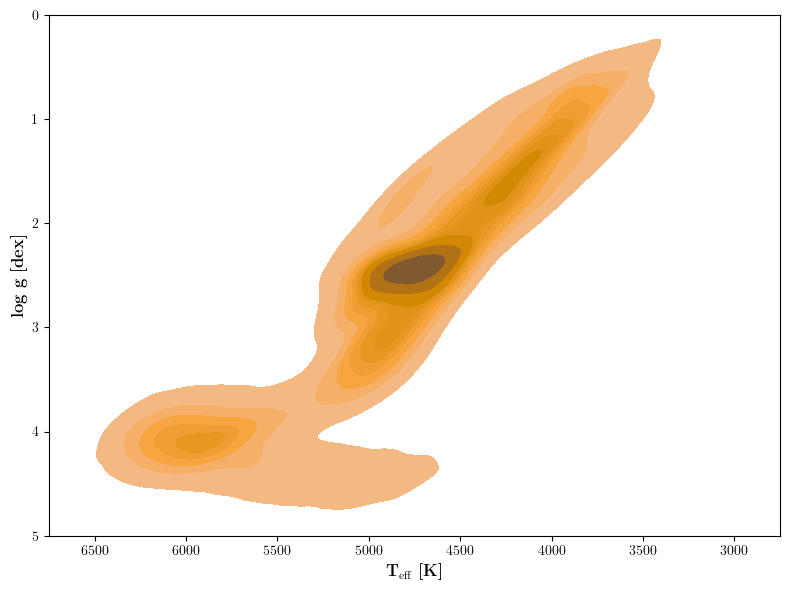

In [91]:
fig1, ax = plt.subplots(figsize=(8, 6))
plot_kiel_diagram(
    target_x=catalog["TEFF"],
    target_y=catalog["LOGG"],
    prior_x=None,
    prior_y=None,
    ax=ax,
    title="",
    xlabel=KIEL_XLABEL,
    ylabel=KIEL_YLABEL,
    target_color="orange",
    target_alpha=1,
    target_label="",
    target_label_linewidth=0,
    plot_prior=False,
    prior_filter=PRIOR_FILTER,
    prior_color=PRIOR_COLOR,
    prior_alpha=PRIOR_ALPHA,
    prior_label=SELECTION_BIAS_KIEL_PRIOR_LEGEND_LABEL,
    prior_label_linewidth=KIEL_LEGEND_LINEWIDTH,
    separation_line_color=SEPARATION_LINE_COLOR,
    separation_line_style=SEPARATION_LINE_STYLE,
    separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
    kde_levels=10,
    kde_thresh=KDE_THRESH,
    kde_linewidths=KDE_LINEWIDTHS,
    plot_reference_star=False,
    reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
    reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
    reference_star_marker=REFERENCE_STAR_MARKER,
    reference_star_color=REFERENCE_STAR_COLOR,
    reference_star_size=REFERENCE_STAR_SIZE,
    reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
    reference_star_label=REFERENCE_STAR_LABEL,
    reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
    crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
    crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
    crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
    kiel_xlim_low=2750,
    kiel_xlim_high=KIEL_XLIM_HIGH,
    kiel_ylim_low=0,
    kiel_ylim_high=KIEL_YLIM_HIGH,
    title_fontsize=TITLE_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
    tick_labelsize=TICK_LABELSIZE,
    legend_fontsize=LEGEND_FONTSIZE,
    legend_location=KIEL_LEGEND_LOCATION,
    figsize_x=SUBPLOT_FIGSIZE_X,
    figsize_y=SUBPLOT_FIGSIZE_Y
)
plt.tight_layout()
plt.savefig('kiel_diagram_good_catalog.png', dpi=400, bbox_inches='tight')
plt.show()

/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/azureuser/miniconda3/envs/milkyjay/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


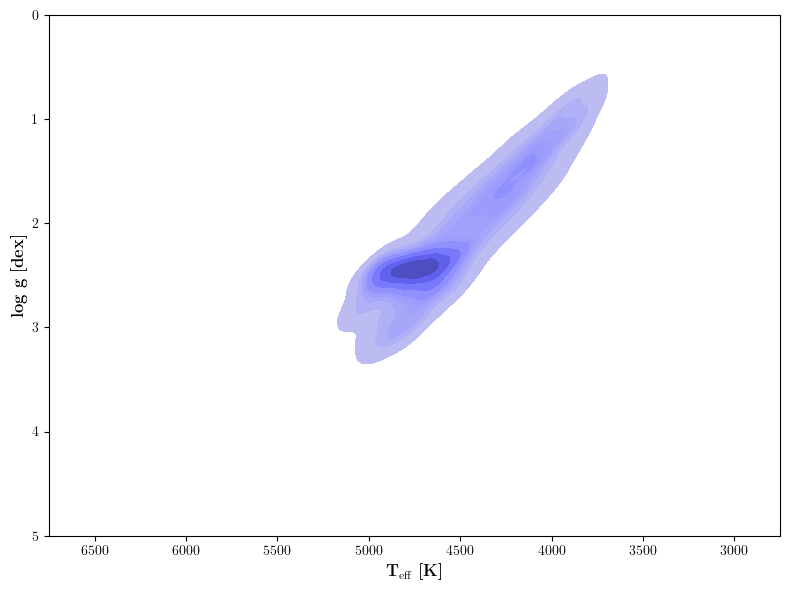

In [90]:
# Plot 2 only - Pristine Catalog/Prior
fig2, ax = plt.subplots(figsize=(8, 6))
plot_kiel_diagram(
    target_x=catalog["TEFF"],
    target_y=catalog["LOGG"],
    prior_x=teff_train_biased,
    prior_y=logg_train_biased,
    ax=ax,
    title="",
    xlabel=KIEL_XLABEL,
    ylabel=KIEL_YLABEL,
    target_color=TARGET_COLOR,
    target_alpha=0,
    target_label="",
    target_label_linewidth=0,
    plot_prior=True,
    prior_filter=PRIOR_FILTER,
    prior_color="blue",
    prior_alpha=1,
    prior_label="",
    prior_label_linewidth=0,
    separation_line_color=SEPARATION_LINE_COLOR,
    separation_line_style=SEPARATION_LINE_STYLE,
    separation_line_linewidth=SEPARATION_LINE_LINEWIDTH,
    kde_levels=10,
    kde_thresh=KDE_THRESH,
    kde_linewidths=KDE_LINEWIDTHS,
    plot_reference_star=False,
    reference_star_teff=REFERENCE_STAR_TEFF_BIASED,
    reference_star_logg=REFERENCE_STAR_LOGG_BIASED,
    reference_star_marker=REFERENCE_STAR_MARKER,
    reference_star_color=REFERENCE_STAR_COLOR,
    reference_star_size=REFERENCE_STAR_SIZE,
    reference_star_edgecolor=REFERENCE_STAR_EDGECOLOR,
    reference_star_label=REFERENCE_STAR_LABEL,
    reference_star_legend_size=REFERENCE_STAR_LEGEND_SIZE,
    crosshair_style=REFERENCE_STAR_CROSSHAIR_STYLE,
    crosshair_color=REFERENCE_STAR_CROSSHAIR_COLOR,
    crosshair_linewidth=REFERENCE_STAR_CROSSHAIR_LINEWIDTH,
    kiel_xlim_low=2750,
    kiel_xlim_high=KIEL_XLIM_HIGH,
    kiel_ylim_low=0,
    kiel_ylim_high=KIEL_YLIM_HIGH,
    title_fontsize=TITLE_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
    tick_labelsize=TICK_LABELSIZE,
    legend_fontsize=LEGEND_FONTSIZE,
    legend_location=KIEL_LEGEND_LOCATION,
    figsize_x=SUBPLOT_FIGSIZE_X,
    figsize_y=SUBPLOT_FIGSIZE_Y
)
plt.tight_layout()
plt.savefig('kiel_diagram_pristine_catalog.png', dpi=400, bbox_inches='tight')
plt.show()